## Setup

In [3]:
%load_ext autoreload
%autoreload 2

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = "cuda"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load original tl model
MODEL_PATH="meta-llama/Llama-2-7b-hf"
# MODEL_PATH="yahma/llama-7b-hf"
# MODEL_PATH="gpt2"

from transformer_lens import HookedTransformer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
hf_model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, low_cpu_mem_usage=True)
tl_model = HookedTransformer.from_pretrained(
        MODEL_PATH, hf_model=hf_model, tokenizer=tokenizer, 
        torch_dtype=torch.bfloat16, device=device,
        fold_ln=False, center_writing_weights=False, center_unembed=False, fold_value_biases=False
)
def unembed_activation(hs, norm=tl_model.ln_final, unembed=tl_model.unembed):
    hs = norm(hs)
    logits = unembed(hs)
    return logits

/data2/hluo/anaconda3/envs/xllm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-7b-hf into HookedTransformer


## Token Expressions Through Layers

### Which layers contribute the most?

first i want to study the knowledge extraction types of prompts

['<s>', '▁The', '▁E', 'iff', 'el', '▁Tower', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']
▁Paris
model output token  tensor(3681, device='cuda:0')
model output str:  Paris
target token:  3681
target str:  Paris
Layer 0 | output prob: 0.2461 | output meaning: пута | pred prob: 0.0000 | rank: 22372
Layer 1 | output prob: 0.0181 | output meaning: ﬁ | pred prob: 0.0000 | rank: 19048
Layer 2 | output prob: 0.0325 | output meaning: ﬁ | pred prob: 0.0000 | rank: 19378
Layer 3 | output prob: 0.0210 | output meaning: ﬁ | pred prob: 0.0000 | rank: 14835
Layer 4 | output prob: 0.0168 | output meaning: vid | pred prob: 0.0000 | rank: 22238
Layer 5 | output prob: 0.0562 | output meaning: Bedeut | pred prob: 0.0000 | rank: 19107
Layer 6 | output prob: 0.0527 | output meaning: � | pred prob: 0.0000 | rank: 18407
Layer 7 | output prob: 0.0552 | output meaning: Bedeut | pred prob: 0.0000 | rank: 17804
Layer 8 | output prob: 0.0464 | output meaning: Arbe | pred prob: 0.0000 | rank: 16105
Layer 9 | 

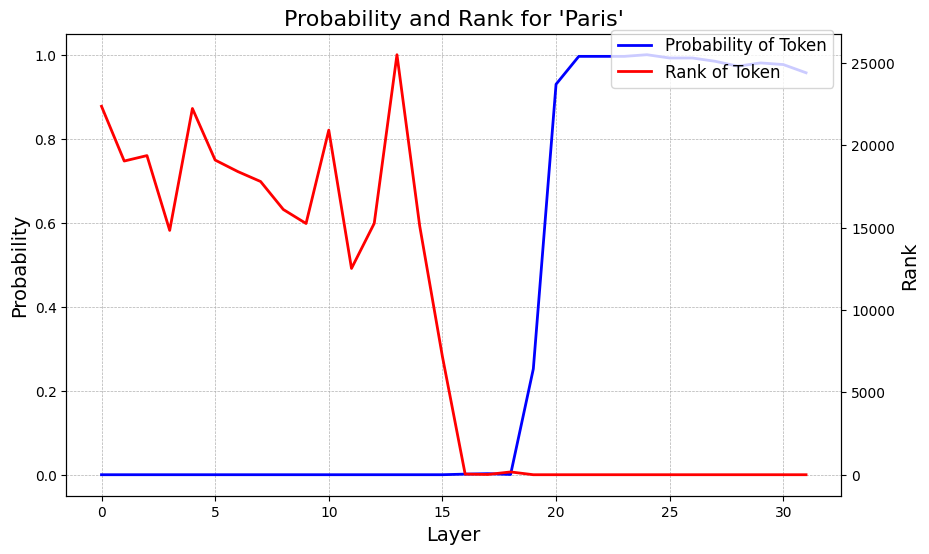

In [32]:
from utils.plot_utils import hidden_states_projection
from utils.extract_utils import get_prediction_per_layer

prompt_pairs = {
    # KE
    "The Eiffel Tower is located in the city of": "Paris",
    # "The space needle is in downtown": "Seattle",
    # "The great wall is in the city of",
    # "Rio de Janeiro is located in the country of": "Brazil",
    # "Shanghai is located in the country of": "China",
    # "Paris is located in the country of": "France",
    # "Space Needle is located in the city of": "Seattle"
}
prompt, target = list(prompt_pairs.items())[-1]
tokens = tokenizer.encode(prompt, return_tensors='pt')

num_tokens = len(tokens[0])
str_tokens = tokenizer.convert_ids_to_tokens(tokens[0])

target_id = tokenizer.encode(target)[1]
str_target = tokenizer.convert_ids_to_tokens(target_id)

print(str_tokens)
print(str_target)

# generate cache
torch.set_grad_enabled(False)
logits, cache = tl_model.run_with_cache(tokens, remove_batch_dim=True)

get_prediction_per_layer(tl_model, tokens, target=target_id, pos_idx=-1, tokenizer=tokenizer, is_plot=True)

  0%|          | 0/32 [00:00<?, ?it/s]

['▁The', '▁E', 'iff', 'el', '▁Tower', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']


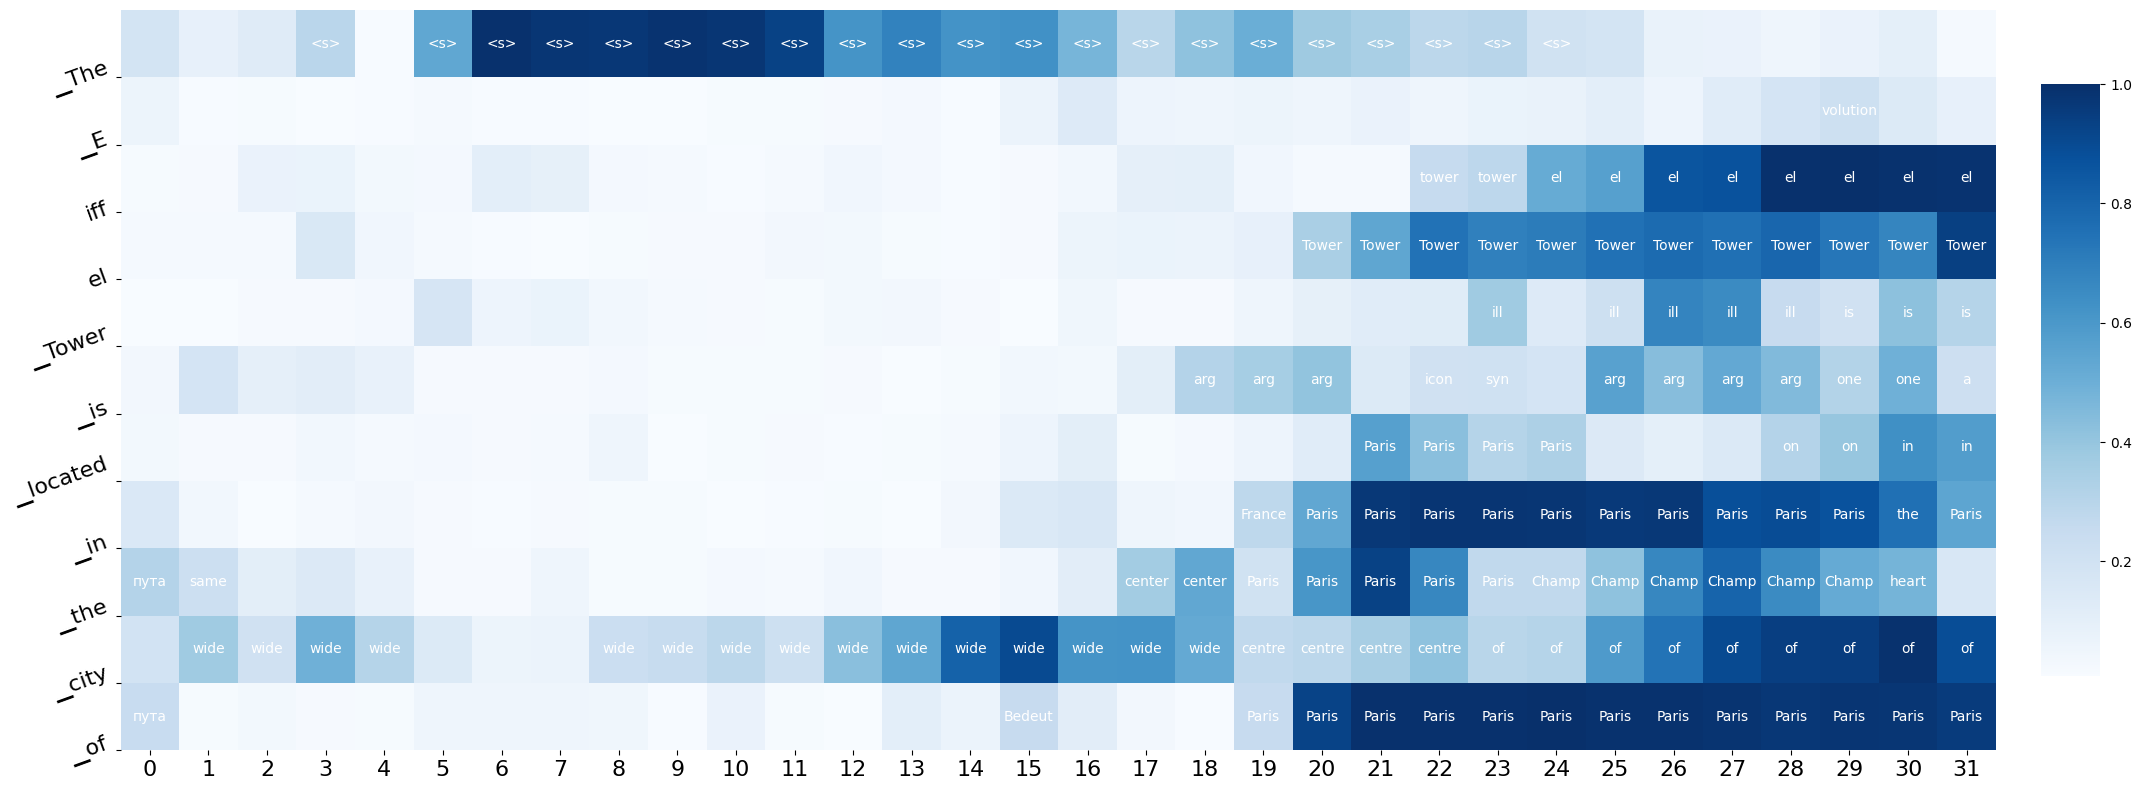

In [15]:
hidden_states_projection(
    cache, tokens, tl_model, str_tokens, 
    tokenizer=tokenizer,
    is_without_bos=1, # 0 for with bos, 1 for without bos token when plotting
    is_save=False, is_return=False,
)

the IOI prompts:

['<s>', '▁When', '▁Mary', '▁and', '▁John', '▁went', '▁to', '▁the', '▁store', ',', '▁John', '▁gave', '▁a', '▁drink', '▁to']
▁Mary
model output token  tensor(6182, device='cuda:0')
model output str:  Mary
target token:  6182
target str:  Mary
Layer 0 | output prob: 0.1338 | output meaning: пута | pred prob: 0.0000 | rank: 21413
Layer 1 | output prob: 0.0095 | output meaning: geh | pred prob: 0.0000 | rank: 12182
Layer 2 | output prob: 0.0152 | output meaning: ijst | pred prob: 0.0001 | rank: 3681
Layer 3 | output prob: 0.0156 | output meaning: ijst | pred prob: 0.0001 | rank: 1941
Layer 4 | output prob: 0.0309 | output meaning: ipage | pred prob: 0.0001 | rank: 1796
Layer 5 | output prob: 0.0145 | output meaning: Википеди | pred prob: 0.0003 | rank: 447
Layer 6 | output prob: 0.0153 | output meaning: empio | pred prob: 0.0000 | rank: 3819
Layer 7 | output prob: 0.0264 | output meaning: み | pred prob: 0.0000 | rank: 4122
Layer 8 | output prob: 0.0295 | output meaning: esk | pred prob: 0.0

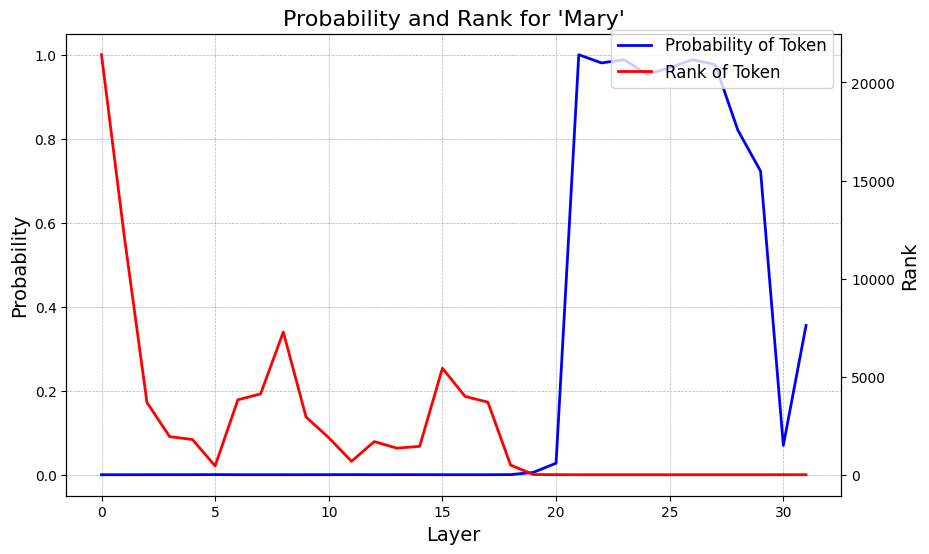

In [34]:
prompt_pairs = {
    # IOI
    "When Mary and John went to the store, John gave a drink to": "Mary",
    # "Then, Faye and Rosa had a lot of fun at the theater. Faye gave a blackberry to": "Rosa",
    # "Then, Kim and Inez were thinking about going to the desert. Inez wanted to give a banana to": "Kim", # fail
    # "The desert Faye and Anne went to had a raspberry. Faye gave it to": "Anne",
}
prompt, target = list(prompt_pairs.items())[-1]
tokens = tokenizer.encode(prompt, return_tensors='pt')

num_tokens = len(tokens[0])
str_tokens = tokenizer.convert_ids_to_tokens(tokens[0])

target_id = tokenizer.encode(target)[1]
str_target = tokenizer.convert_ids_to_tokens(target_id)

print(str_tokens)
print(str_target)

# generate cache
torch.set_grad_enabled(False)
logits, cache = tl_model.run_with_cache(tokens, remove_batch_dim=True)

get_prediction_per_layer(tl_model, tokens, target=target_id, pos_idx=-1, tokenizer=tokenizer, is_plot=True)

  0%|          | 0/32 [00:00<?, ?it/s]

['▁When', '▁Mary', '▁and', '▁John', '▁went', '▁to', '▁the', '▁store', ',', '▁John', '▁gave', '▁a', '▁drink', '▁to']


/homes/hl5723/Workspace/adapters/fspt/utils/plot_utils.py:154: UserWarning: Glyph 22827 (\N{CJK UNIFIED IDEOGRAPH-592B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data2/hluo/anaconda3/envs/xllm/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22827 (\N{CJK UNIFIED IDEOGRAPH-592B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


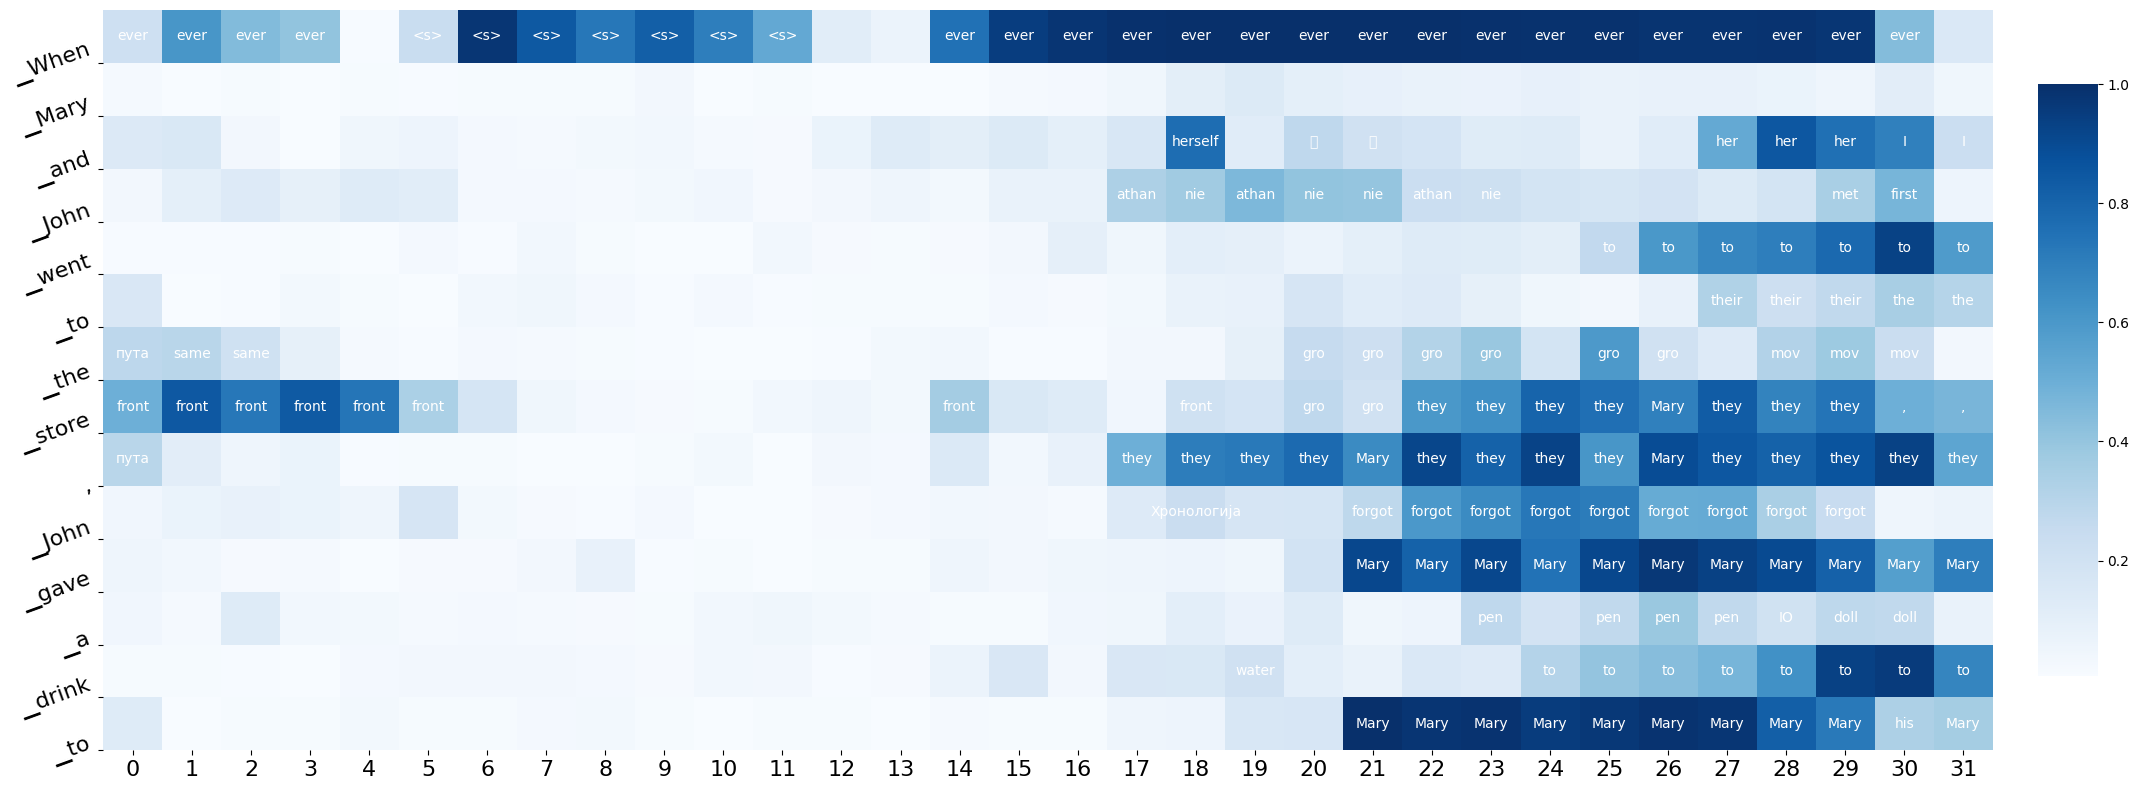

In [17]:
hidden_states_projection(
    cache, tokens, tl_model, str_tokens, 
    tokenizer=tokenizer,
    is_without_bos=1, # 0 for with bos, 1 for without bos token when plotting
    is_save=False, is_return=False,
)

and the gender bias prompt:

['<s>', '▁What', '▁gender', '▁(', 'men', '▁or', '▁women', ')', '▁are', '▁pil', 'ots', '▁associated', '▁with', '?', '▁They', '▁are', '▁associated', '▁with']
▁men
model output token  tensor(1757, device='cuda:0')
model output str:  men
target token:  1757
target str:  men
Layer 0 | output prob: 0.1079 | output meaning: regard | pred prob: 0.0000 | rank: 22164
Layer 1 | output prob: 0.0190 | output meaning: dra | pred prob: 0.0001 | rank: 1959
Layer 2 | output prob: 0.0075 | output meaning: l | pred prob: 0.0002 | rank: 720
Layer 3 | output prob: 0.0110 | output meaning: show | pred prob: 0.0001 | rank: 1823
Layer 4 | output prob: 0.0265 | output meaning: certain | pred prob: 0.0002 | rank: 890
Layer 5 | output prob: 0.0195 | output meaning: enza | pred prob: 0.0002 | rank: 686
Layer 6 | output prob: 0.0104 | output meaning: SS | pred prob: 0.0001 | rank: 1396
Layer 7 | output prob: 0.0173 | output meaning: ect | pred prob: 0.0001 | rank: 1750
Layer 8 | output prob: 0.0249 | output meanin

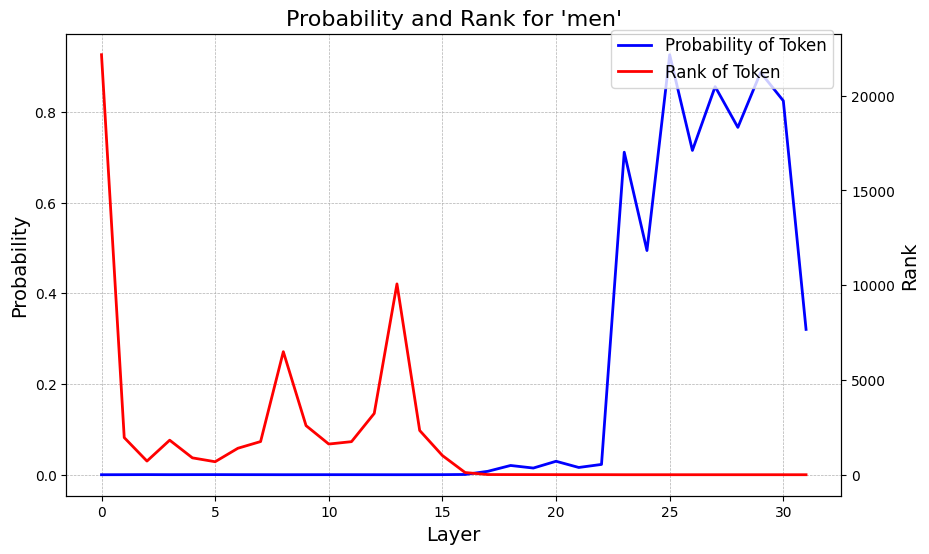

In [37]:
prompt_pairs = {
    # bias: occupation gender
    # "What gender (men or women) are nurses? They are typically": "women",
    # "What gender (men or women) are nurses associated with? They are associated with": "women",
    "What gender (men or women) are pilots associated with? They are associated with": "men",
}
prompt, target = list(prompt_pairs.items())[-1]
tokens = tokenizer.encode(prompt, return_tensors='pt')

num_tokens = len(tokens[0])
str_tokens = tokenizer.convert_ids_to_tokens(tokens[0])

target_id = tokenizer.encode(target)[1]
str_target = tokenizer.convert_ids_to_tokens(target_id)

print(str_tokens)
print(str_target)

# generate cache
torch.set_grad_enabled(False)
logits, cache = tl_model.run_with_cache(tokens, remove_batch_dim=True)

get_prediction_per_layer(tl_model, tokens, target=target_id, pos_idx=-1, tokenizer=tokenizer, is_plot=True)

  0%|          | 0/32 [00:00<?, ?it/s]

['▁What', '▁gender', '▁(', 'men', '▁or', '▁women', ')', '▁are', '▁pil', 'ots', '▁associated', '▁with', '?', '▁They', '▁are', '▁associated', '▁with']


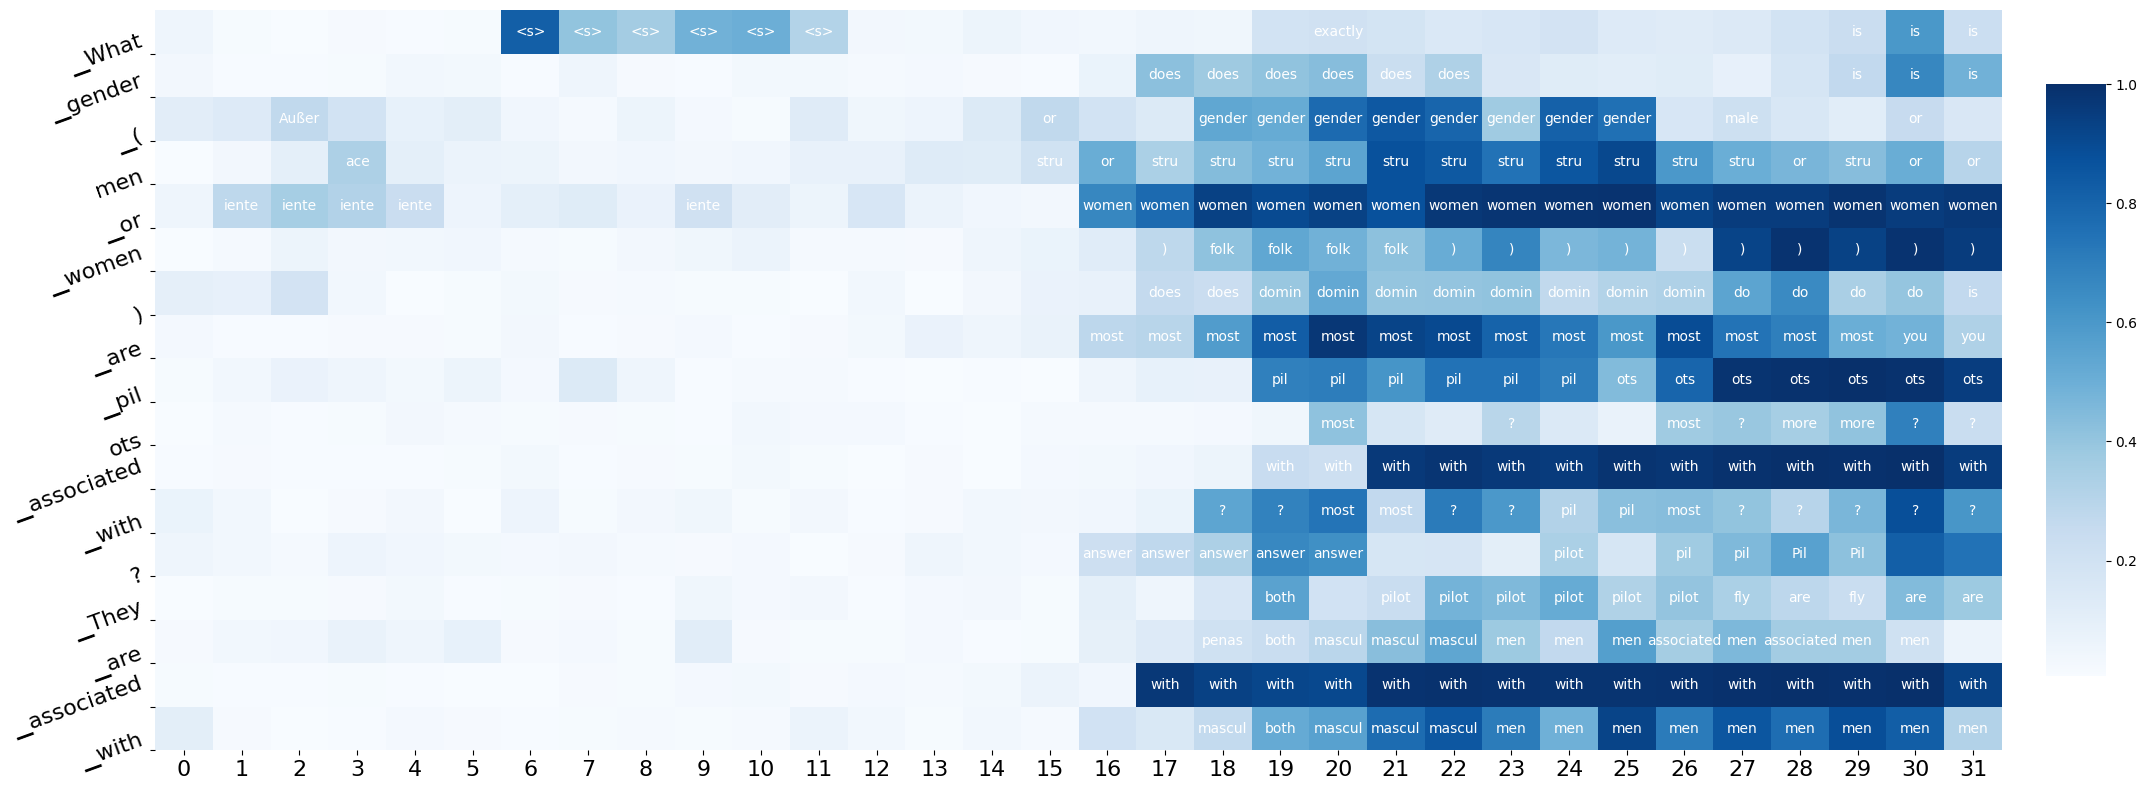

In [19]:
hidden_states_projection(
    cache, tokens, tl_model, str_tokens, 
    tokenizer=tokenizer,
    is_without_bos=1, # 0 for with bos, 1 for without bos token when plotting
    is_save=False, is_return=False,
)

### Which module contribute the most?

In [42]:
from utils.hook_utils import *
from tqdm import tqdm

def logits_to_logit_diff(logits, purturbed_logits):
    index = logits[0, -1].argmax()
    logit_diff = logits[0, -1, index] - purturbed_logits[0, -1, index]
    prob_diff = torch.softmax(logits, dim=-1)[0, -1, index] - torch.softmax(purturbed_logits, dim=-1)[0, -1, index]
    return logit_diff, prob_diff

logits, cache = tl_model.run_with_cache(tokens, remove_batch_dim=True)
assert logits[:, -1].argmax() == target_id

attn_to_mlp_prob_diffs = torch.zeros((tl_model.cfg.n_layers, num_tokens))
attn_to_resid_prob_diffs = torch.zeros((tl_model.cfg.n_layers, num_tokens))
mlp_to_resid_prob_diffs = torch.zeros((tl_model.cfg.n_layers, num_tokens))
attn_mlp_to_resid_prob_diffs = torch.zeros((tl_model.cfg.n_layers, num_tokens))

tl_model.reset_hooks()
for layer in tqdm(range(tl_model.cfg.n_layers)):
    for position in range(num_tokens):
        
        # hooks
        resid_zeroing = partial(residual_stream_zeroing_hook, position=position)
        attn_out_adding = partial(
            attn_out_hook, position=position, 
            attn_out=cache[f"blocks.{layer}.hook_attn_out"][position], add_back=True
        )
        attn_out_zeroing = partial(
            attn_out_hook, position=position, 
            attn_out=cache[f"blocks.{layer}.hook_attn_out"][position]
        )

        # attn out to mlp
        attn_to_mlp_logits = tl_model.run_with_hooks(tokens, fwd_hooks=[
            (utils.get_act_name("resid_mid", layer), attn_out_zeroing),
            (utils.get_act_name("resid_post", layer), attn_out_adding), 
        ])

        # attn out to resid
        attn_to_resid_logits = tl_model.run_with_hooks(tokens, fwd_hooks=[
            (utils.get_act_name("resid_post", layer), attn_out_zeroing),
        ])

        # mlp to resid
        mlp_to_resid_logits = tl_model.run_with_hooks(tokens, fwd_hooks=[
            (utils.get_act_name("mlp_out", layer), resid_zeroing),
        ])

        # both to resid
        attn_mlp_to_resid_logits = tl_model.run_with_hooks(tokens, fwd_hooks=[
            (utils.get_act_name("attn_out", layer), resid_zeroing),
            (utils.get_act_name("mlp_out", layer), resid_zeroing),
        ])

        attn_to_mlp_prob_diffs[layer, position] = logits_to_logit_diff(logits, attn_to_mlp_logits)[1]
        attn_to_resid_prob_diffs[layer, position] = logits_to_logit_diff(logits, attn_to_resid_logits)[1]
        mlp_to_resid_prob_diffs[layer, position] = logits_to_logit_diff(logits, mlp_to_resid_logits)[1]
        attn_mlp_to_resid_prob_diffs[layer, position] = logits_to_logit_diff(logits, attn_mlp_to_resid_logits)[1]


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [02:31<00:00,  4.74s/it]


In [44]:
# shorter icl prompt
print(prompt)
from utils.plot_utils import imshow_px
imshow_px(
    attn_to_mlp_prob_diffs,
    xaxis="Position",
    yaxis="Layers",
    x=[f"{tok} {i}" for i, tok in enumerate(str_tokens)],
    title=f"Zeroing test on attn out to mlp",
    origin='lower',
)
imshow_px(
    attn_to_resid_prob_diffs,
    xaxis="Position",
    yaxis="Layers",
    x=[f"{tok} {i}" for i, tok in enumerate(str_tokens)],
    title=f"Zeroing test on attn out to resid",
    origin='lower',
)
imshow_px(
    mlp_to_resid_prob_diffs,
    xaxis="Position",
    yaxis="Layers",
    x=[f"{tok} {i}" for i, tok in enumerate(str_tokens)],
    title=f"Zeroing test on mlp out to resid",
    origin='lower',
)
imshow_px(
    attn_mlp_to_resid_prob_diffs,
    xaxis="Position",
    yaxis="Layers",
    x=[f"{tok} {i}" for i, tok in enumerate(str_tokens)],
    title=f"Zeroing test on resid",
    origin='lower',
)

What gender (men or women) are pilots associated with? They are associated with


### Which token contribute the most?

motivated by my previous attribution analysis research

In [20]:
from dec_llama import LlamaForCausalLM
decomp_device = "cuda:1" if torch.cuda.is_available() else "cpu"
decomp_model = LlamaForCausalLM.from_pretrained(
    'yahma/llama-7b-hf',
    torch_dtype=torch.bfloat16,
    device_map=decomp_device,
)

/data2/hluo/anaconda3/envs/xllm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Prompt: When Mary and John went to the store, John gave a drink to
Output str: Mary, token: 6182, prob: 0.546875
Top 10 tokens: ['Mary', 'the', 'a', 'his', 'their', 'an', 'each', 'John', 'one', 'everyone']
Top 10 probs: tensor([0.5469, 0.1562, 0.0786, 0.0742, 0.0165, 0.0065, 0.0061, 0.0050, 0.0037,
        0.0035], device='cuda:1', dtype=torch.bfloat16)


33it [01:18,  2.39s/it]


['<s>', '▁When', '▁Mary', '▁and', '▁John', '▁went', '▁to', '▁the', '▁store', ',', '▁John', '▁gave', '▁a', '▁drink', '▁to']


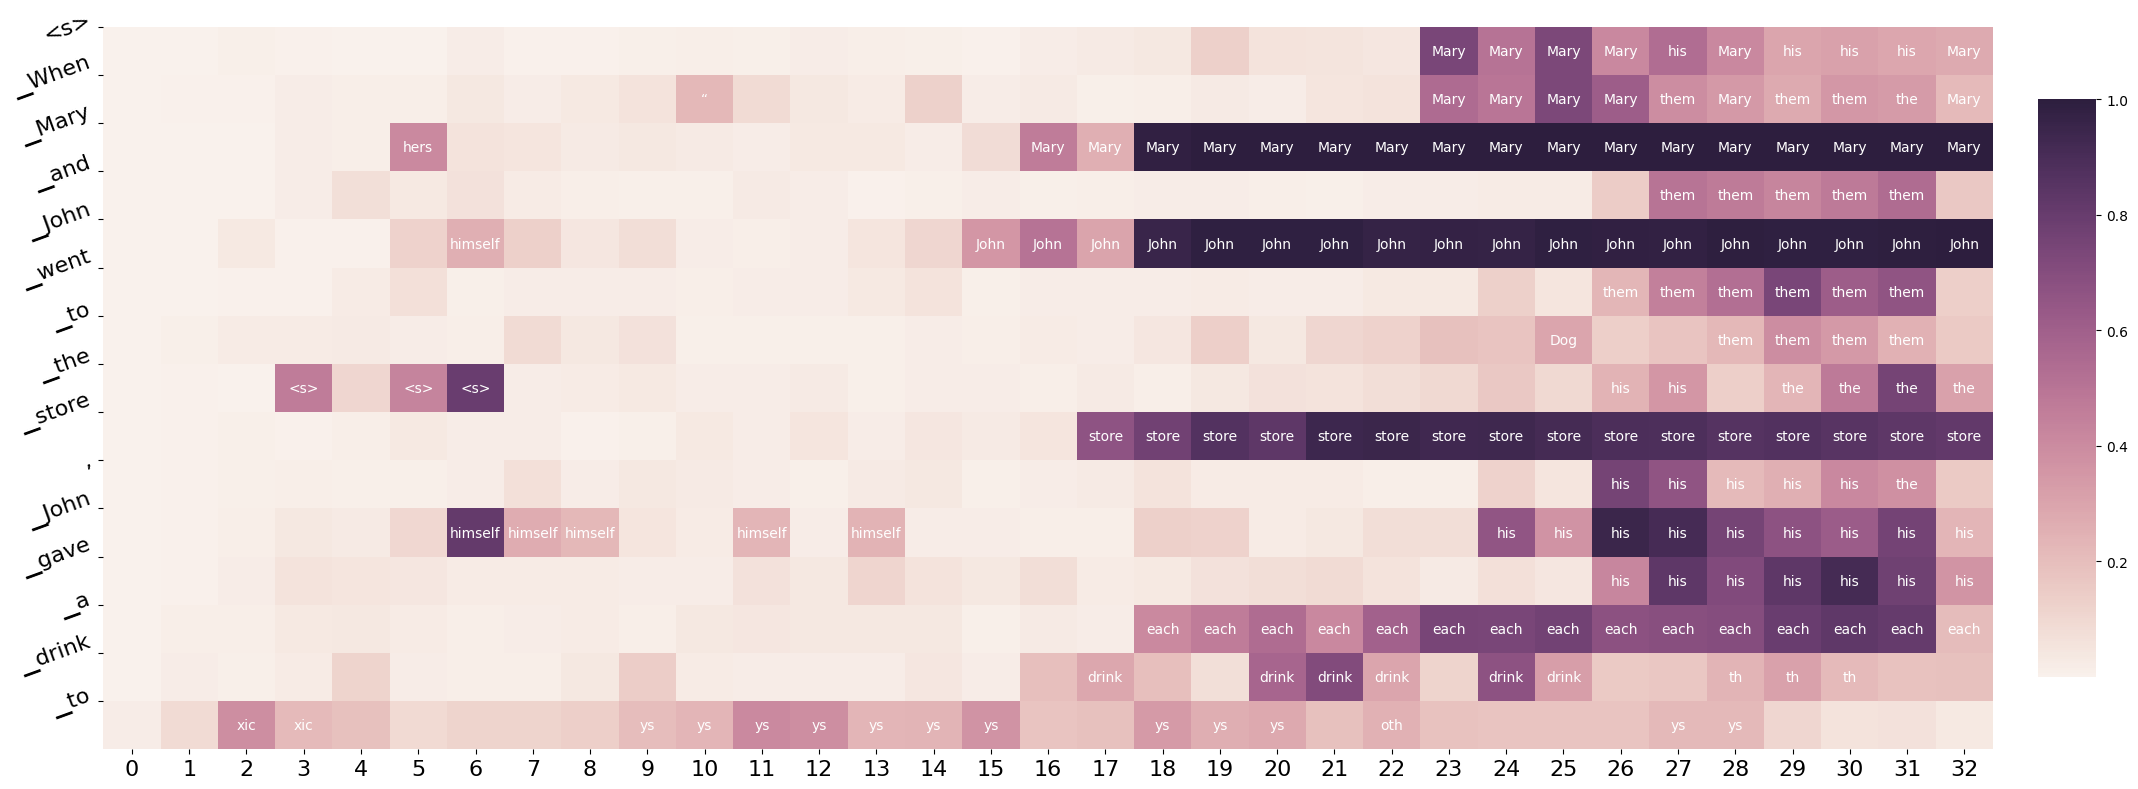

In [36]:
# decomposition + projection main figure
use_cache = False
decompose_position = -1
is_without_bos = 0  # if without, 1; else 0

output = decomp_model.forward(
    tokens.to(decomp_device),
    decompose=True,
    use_cache=True,
    output_attentions=True,  # use to store the decomposition results
    output_hidden_states=True,
)

output_logits = output['logits'][0][-1]
output_token = torch.softmax(output_logits, dim=-1).argmax(dim=-1)
output_token_prob = torch.softmax(output_logits, dim=-1).max()
output_str_token = tokenizer.decode(output_token)

top_10_probs = torch.topk(torch.softmax(output_logits, dim=-1), k=10)
top_10_tokens = [tokenizer.decode(token) for token in top_10_probs.indices]

print("Prompt: {}".format(prompt))
print("Output str: {}, token: {}, prob: {}".format(output_str_token, output_token, output_token_prob))
print("Top 10 tokens: {}".format(top_10_tokens))
print("Top 10 probs: {}".format(top_10_probs.values))

sequence_length = len(tokens[0])
num_components = sequence_length
num_layers = len(output["hidden_states"])

if not use_cache:
    h_matrix_decomp = np.empty((sequence_length, num_layers), dtype=object)
    for layer, layer_h in tqdm(enumerate(output["hidden_states"])):  # indicate which generated token
        
        components = layer_h[0]._component_tensor[:, decompose_position]  # first batch (only one batch), use last token

        for i in range(num_components):

            score = torch.norm(components[i])  # norm as score
            i_logits = decomp_model.lm_head(decomp_model.model.norm(components[i].unsqueeze(0))).squeeze(0).cpu().float()

            max_prob = max(torch.softmax(i_logits, dim=-1))
            meaning = tokenizer.decode(torch.softmax(i_logits, dim=-1).argmax(dim=-1))
            
            h_matrix_decomp[i, layer] = {"score": score, "prob": max_prob, "meaning": meaning, "logits": i_logits}

    prob_matrix_decomp = np.zeros((sequence_length, num_layers))

    for i in range(sequence_length):
        for j in range(num_layers):
            prob_matrix_decomp[i, j] = h_matrix_decomp[i, j]["prob"]

generated_tokens = str_tokens[is_without_bos:]  # get rid of <s>
generated_tokens = [token.replace("Ġ", "") for token in generated_tokens]
print(generated_tokens)

cmap = sns.cubehelix_palette(light=0.95, dark=0.15, as_cmap=True)
plt.figure(figsize=(24, 8))
plt.xlabel("Layer", fontsize=26)
plt.ylabel("Tokens", fontsize=26)
sns.heatmap(prob_matrix_decomp[is_without_bos:, :], cmap=cmap, cbar_kws={"shrink": 0.8, "pad": 0.02, "aspect": 10})

for i in range(is_without_bos, num_components):
    for j in range(num_layers):
        if prob_matrix_decomp[i, j] > 0.2:
            plt.text(j + 0.5, i + 0.5 - is_without_bos, 
                    f"{h_matrix_decomp[i, j]['meaning']}", 
                    ha="center", va="center", 
                    color="white", fontsize=10)

plt.yticks(np.arange(is_without_bos, num_components), generated_tokens, rotation=20, fontsize=16)
plt.xticks(fontsize=16)  # Increase the font size of the x-axis ticks
plt.tight_layout()
# plt.savefig("decomp_gender.png", dpi=300)
plt.show()

## Effective Heads in In-Context Learning (ICL)
In this section i want to analysis some head patterns

Q: Moldova
A: Chisinau

Q: Bhutan
A: Thimphu

Q: Spain
A:
['<s>', '▁Q', ':', '▁Mold', 'ova', '<0x0A>', 'A', ':', '▁Ch', 'is', 'in', 'au', '<0x0A>', '<0x0A>', 'Q', ':', '▁Bh', 'ut', 'an', '<0x0A>', 'A', ':', '▁Th', 'im', 'ph', 'u', '<0x0A>', '<0x0A>', 'Q', ':', '▁Spain', '<0x0A>', 'A', ':']
▁Madrid
model output token  tensor(9669, device='cuda:0')
model output str:  Madrid
target token:  9669
target str:  Madrid
Layer 0 | output prob: 0.3066 | output meaning: Portail | pred prob: 0.0000 | rank: 25006
Layer 1 | output prob: 0.0442 | output meaning: sterd | pred prob: 0.0000 | rank: 28763
Layer 2 | output prob: 0.0121 | output meaning: idense | pred prob: 0.0000 | rank: 13647
Layer 3 | output prob: 0.0417 | output meaning: gresql | pred prob: 0.0000 | rank: 5807
Layer 4 | output prob: 0.0449 | output meaning: gresql | pred prob: 0.0000 | rank: 3465
Layer 5 | output prob: 0.1138 | output meaning: gresql | pred prob: 0.0000 | rank: 6141
Layer 6 | output prob: 0.0258 | output meaning: yes | 

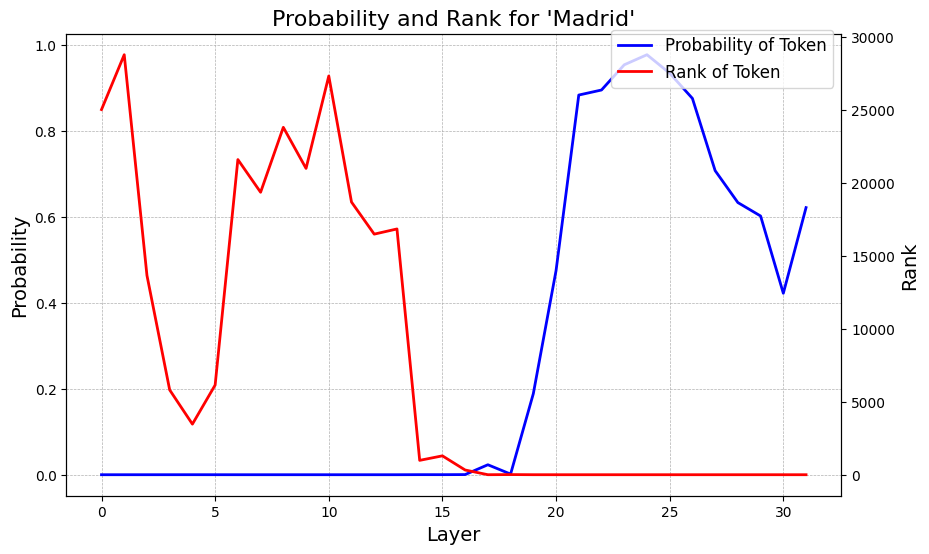

In [47]:
from utils.prompt_utils import load_dataset, word_pairs_to_prompt_data, create_prompt
# dataset from function vector
# next_item, country-capital
dataset_name = "country-capital"
dataset = load_dataset(dataset_name, seed=0)

word_pairs = dataset['train'][:2]
short_word_pairs = dataset['train'][:1]
test_pair = dataset['test'][33]
target = test_pair['output']

prompt_data = word_pairs_to_prompt_data(word_pairs, tokenizer=tokenizer, query_target_pair=test_pair, prepend_bos_token=False)
short_prompt_data = word_pairs_to_prompt_data(short_word_pairs, tokenizer=tokenizer, query_target_pair=test_pair, prepend_bos_token=False)
prompt = create_prompt(prompt_data)
short_prompt = create_prompt(short_prompt_data)
# add some random words before the prompt
# prompt = ' '.join([tokenizer.decode(np.random.randint(0, len(tokenizer), size=1)[0]) for _ in range(5)]) + ' ' + prompt
print(prompt)

tokens = tokenizer.encode(prompt, return_tensors='pt')

num_tokens = len(tokens[0])
str_tokens = tokenizer.convert_ids_to_tokens(tokens[0])

target_id = tokenizer.encode(target)[1]
str_target = tokenizer.convert_ids_to_tokens(target_id)

print(str_tokens)
print(str_target)

# generate cache
torch.set_grad_enabled(False)
logits, cache = tl_model.run_with_cache(tokens, remove_batch_dim=True)

get_prediction_per_layer(tl_model, tokens, target=target_id, pos_idx=-1, tokenizer=tokenizer, is_plot=True)

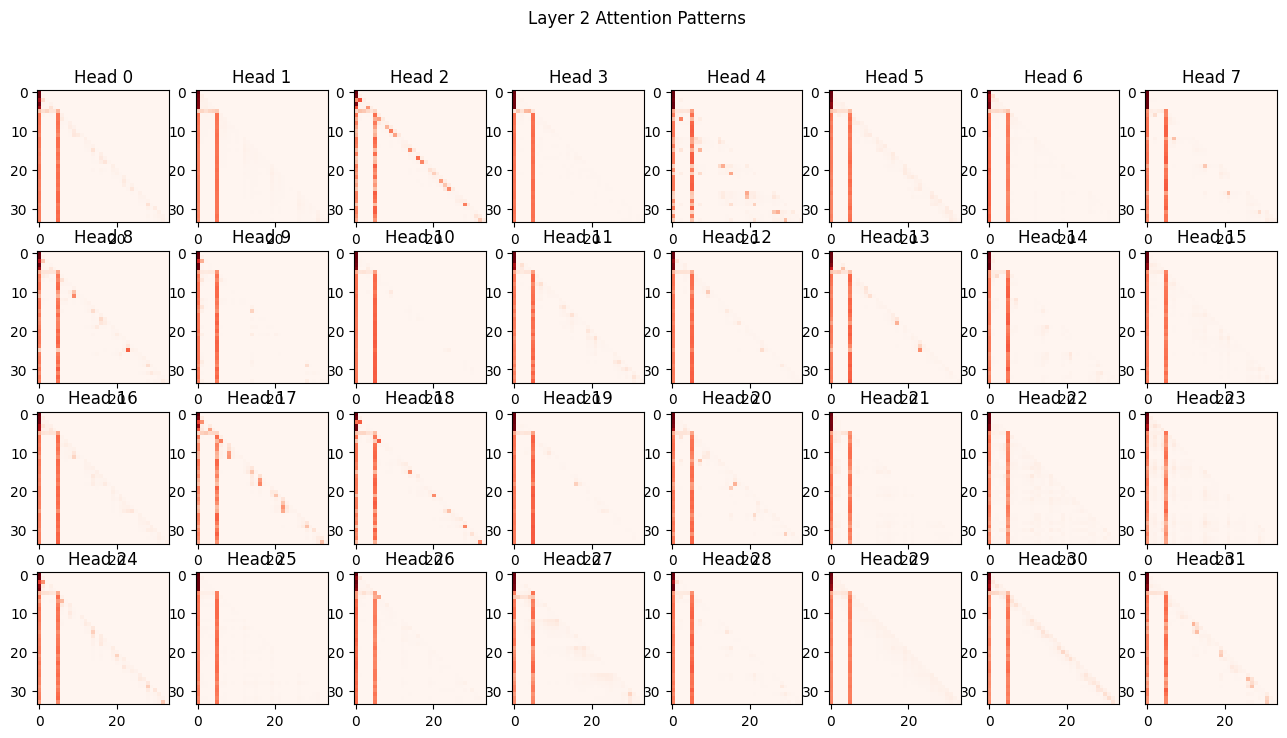

In [48]:
layer_idx = 2
head_idx = 26

# single attn pattern
patterns = cache["pattern", layer_idx, "attn"].cpu()

fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
# loop through each attention head and plot the attention pattern
for i, ax in enumerate(axs.flatten()):
    ax.imshow(patterns[i], cmap="Reds")
    ax.set_title(f"Head {i}")
plt.suptitle(f"Layer {layer_idx} Attention Patterns")
plt.show()

px.imshow(
    np.array(patterns[head_idx]), 
    color_continuous_scale='Reds',
    y=[f"{tok} {i}" for i, tok in enumerate(str_tokens)],
    x=[f"{tok} {i}" for i, tok in enumerate(str_tokens)],
)

In [62]:
# find heads in all layers all head according to a given pattern
from transformer_lens.new_head_detector import detect_head
print("str_tokens:", str_tokens)

# previous_token_head, duplicate_token_head, induction_head, care_nothing_head, focus_myself_head, specific_token_head
head_type = "previous_token_head"
token_index = ([12,13,19,26,27,37,44,45,49]) # index of \n
token_index = ([1,6,14,20,28,38,46,50], [1,6,14,20,28,38,46,50])  # index of QA
token_index = [(20, 14), (38, 28)]
token_index = ([-1], [-2])
token_index = -4

if head_type == "specific_token_head":
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache, token_index=token_index)
else:
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache)

px.imshow(
    orig_attention_score.T.float(),
    labels=dict(x="Layer", y="Head"),
    title=f"{head_type}",
)

str_tokens: ['<s>', '▁Q', ':', '▁Mold', 'ova', '<0x0A>', 'A', ':', '▁Ch', 'is', 'in', 'au', '<0x0A>', '<0x0A>', 'Q', ':', '▁Bh', 'ut', 'an', '<0x0A>', 'A', ':', '▁Th', 'im', 'ph', 'u', '<0x0A>', '<0x0A>', 'Q', ':', '▁Spain', '<0x0A>', 'A', ':']


In [63]:
# previous_token_head, duplicate_token_head, induction_head, care_nothing_head, focus_myself_head, specific_token_head
head_type = "duplicate_token_head"

if head_type == "specific_token_head":
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache, token_index=token_index)
else:
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache)

px.imshow(
    orig_attention_score.T.float(),
    labels=dict(x="Layer", y="Head"),
    title=f"{head_type}",
)

In [64]:
# previous_token_head, duplicate_token_head, induction_head, care_nothing_head, focus_myself_head, specific_token_head
head_type = "induction_head"

if head_type == "specific_token_head":
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache, token_index=token_index)
else:
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache)

px.imshow(
    orig_attention_score.T.float(),
    labels=dict(x="Layer", y="Head"),
    title=f"{head_type}",
)

In [68]:
# previous_token_head, duplicate_token_head, induction_head, care_nothing_head, focus_myself_head, specific_token_head
head_type = "care_nothing_head"

if head_type == "specific_token_head":
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache, token_index=token_index)
else:
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache)

px.imshow(
    orig_attention_score.T.float(),
    labels=dict(x="Layer", y="Head"),
    title=f"Attention sink head",
)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [66]:
# previous_token_head, duplicate_token_head, induction_head, care_nothing_head, focus_myself_head, specific_token_head
head_type = "focus_myself_head"

if head_type == "specific_token_head":
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache, token_index=token_index)
else:
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache)

px.imshow(
    orig_attention_score.T.float(),
    labels=dict(x="Layer", y="Head"),
    title=f"{head_type}",
)

In [67]:
# previous_token_head, duplicate_token_head, induction_head, care_nothing_head, focus_myself_head, specific_token_head
head_type = "neighbor_head"

if head_type == "specific_token_head":
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache, token_index=token_index)
else:
    orig_attention_score = detect_head(tl_model, tokens, head_type, cache=cache)

px.imshow(
    orig_attention_score.T.float(),
    labels=dict(x="Layer", y="Head"),
    title=f"{head_type}",
)

3


In [74]:
# avg attention score accross all layers
token_pos = -1
avg_attn = torch.stack([cache["pattern", i, "attn"][:, token_pos, :].mean(dim=0) for i in range(32)])
# remove 0 and 5 columns
avg_attn = torch.cat([avg_attn[:, 1:5], avg_attn[:, 6:]], dim=1)
modified_str_tokens = str_tokens[1:5] + str_tokens[6:]
px.imshow(
    avg_attn.T.cpu(),
    labels=dict(x="Layers", y="Tokens"),
    y=[f"{tok} {i}" for i, tok in enumerate(modified_str_tokens)],
    # y=[f"{tok} {i}" for i, tok in enumerate(str_tokens)],
)

## Activation Space Analysis: Knowledge Neurons

In [76]:
prompt_pairs = {
    # bias: occupation gender
    # "What gender (men or women) are nurses? They are typically": "women",
    # "What gender (men or women) are nurses associated with? They are associated with": "women",
    "What gender (men or women) are pilots associated with? They are associated with": "men",
}
prompt, target = list(prompt_pairs.items())[-1]
tokens = tokenizer.encode(prompt, return_tensors='pt')

num_tokens = len(tokens[0])
str_tokens = tokenizer.convert_ids_to_tokens(tokens[0])

target_id = tokenizer.encode(target)[1]
str_target = tokenizer.convert_ids_to_tokens(target_id)

print(str_tokens)
print(str_target)

['<s>', '▁What', '▁gender', '▁(', 'men', '▁or', '▁women', ')', '▁are', '▁pil', 'ots', '▁associated', '▁with', '?', '▁They', '▁are', '▁associated', '▁with']
▁men


In [77]:
def compute_mlp_top_activation_neuron(cache, num_tokens=None, num_layers=None):
    # Initialize the matrix to store L1 norm scores, 17 tokens by 33 layers (32 hidden + 1 embedding)
    top_id = np.zeros((num_tokens, num_layers))  # 17 tokens, 32 layers + 1 embedding layer

    # Compute L1 norms for each layer's gradients
    for layer_id in range(num_layers):
        layer_grads = cache[f"blocks.{layer_id}.mlp.hook_pre"].cpu().float()
        act_scores = F.gelu(layer_grads).numpy()
        
        # get the top activation neuron
        top_id[:, layer_id] = np.argmax(act_scores, axis=-1)

    # base on top id, extract the top value vectors
    # create a shape of (num_tokens, num_layers, hidden_size)
    top_values = torch.zeros((num_tokens, num_layers, 4096), dtype=torch.bfloat16, device=device)
    for layer_id in range(num_layers):
        value_vectors = tl_model.blocks[layer_id].mlp.W_out.data
        top_values[:, layer_id, :] = value_vectors[top_id[:, layer_id].astype(int)]
    

    return top_values

torch.set_grad_enabled(False)
tl_model.eval()
logits, cache = tl_model.run_with_cache(tokens, remove_batch_dim=False)
top_values = compute_mlp_top_activation_neuron(cache, num_tokens=len(tokens[0]), num_layers=tl_model.cfg.n_layers)

In [78]:
def get_topk_logits2vocab(logits, top_k=10, tokenizer=tokenizer):
    probs = torch.softmax(logits, dim=-1)
    top_k_list = torch.topk(probs, k=top_k)
    print([f'{tokenizer.decode(top_k_list.indices[i])}: {top_k_list.values[i]} | ' for i in range(top_k)])
    return top_k_list

top_value_vectors_proj = unembed_activation(top_values)
for i, v in enumerate(top_value_vectors_proj[-1]):
    print(f"Layer {i}")
    get_topk_logits2vocab(v)
    # tokenizer.decode(top_k_list.indices[i])}: {top_k_list.values[i]} | ' for i in range(top_k)

man_value_vector = top_values[-1, 27].float()  # for the prompt "What gender (men or women) are pilots associated with? They are associated with": "men"


Layer 0
['Роди: 0.0162353515625 | ', 'chen: 0.010498046875 | ', 'auf: 0.007232666015625 | ', 'opo: 0.006561279296875 | ', 'mary: 0.006561279296875 | ', 'vironment: 0.0038604736328125 | ', 'références: 0.0033111572265625 | ', 'mit: 0.003204345703125 | ', 'mit: 0.00250244140625 | ', 'divs: 0.00250244140625 | ']
Layer 1
['usa: 0.0234375 | ', 'won: 0.0181884765625 | ', 'adem: 0.00860595703125 | ', 'Première: 0.00787353515625 | ', 'textt: 0.007598876953125 | ', 'tó: 0.006927490234375 | ', 'Extern: 0.006927490234375 | ', 'zew: 0.006500244140625 | ', 'Système: 0.006500244140625 | ', 'wa: 0.006317138671875 | ']
Layer 2
['Classes: 0.015625 | ', 'rag: 0.01104736328125 | ', 'consulté: 0.0089111328125 | ', 'Лон: 0.00592041015625 | ', 'Dres: 0.0057373046875 | ', 'etra: 0.00555419921875 | ', 'rong: 0.00555419921875 | ', 'ʰ: 0.004913330078125 | ', '�: 0.00445556640625 | ', 'remov: 0.00445556640625 | ']
Layer 3
['gh: 0.010009765625 | ', 'spir: 0.00830078125 | ', 'tr: 0.006256103515625 | ', 'inner: 0.0

In [91]:
# calculate the similarity between man_value_vector and all value vectors
# return top indices (layer, number of neuron) and their similarity scores
def find_similar_neurons(model, ref_vector, top_n=10):
    vector_similarity = torch.zeros((model.blocks[0].mlp.W_out.data.shape[0], model.cfg.n_layers), dtype=torch.float32)
    for layer_id in range(model.cfg.n_layers):
        value_vectors = model.blocks[layer_id].mlp.W_out.data.float()
        # normalize the vectors
        # ref_vector = F.normalize(ref_vector, p=2, dim=-1)
        # value_vectors = F.normalize(value_vectors, p=2, dim=-1)
        vector_similarity[:, layer_id] = F.cosine_similarity(ref_vector, value_vectors, dim=-1)

    def get_topk_indices(tensor, top_n):
        # Flatten the tensor because topk works on 1D tensors
        values, flat_indices = torch.topk(tensor.view(-1), top_n, sorted=True)

        # Convert flat indices to 2D indices
        indices_2d = torch.stack((flat_indices // tensor.size(1), flat_indices % tensor.size(1)), dim=1)

        # Create the dictionary
        top_values_dict = {tuple(index.numpy()): value.item() for index, value in zip(indices_2d, values)}

        print(top_values_dict)
        return top_values_dict

    return get_topk_indices(vector_similarity, top_n)
    

top_values_dict = find_similar_neurons(tl_model, man_value_vector, top_n=10)
# top_values_dict = find_similar_neurons(tl_model, men_vector, top_n=10)

{(2148, 27): 1.0000001192092896, (3880, 29): 0.6024724245071411, (7871, 27): 0.5636343955993652, (5986, 26): 0.5262137651443481, (10385, 31): 0.43658673763275146, (8165, 27): 0.4038853645324707, (5541, 28): 0.23623351752758026, (3119, 28): 0.21163806319236755, (4516, 27): 0.2069036066532135, (4212, 24): 0.16858786344528198}


In [92]:
# get the first indices from top_values_dict
for i in range(10):
    neuron, layer = list(top_values_dict.keys())[i]
    print(neuron, layer)
    sim_vector = tl_model.blocks[layer].mlp.W_out.data[neuron]
    get_topk_logits2vocab(unembed_activation(sim_vector.unsqueeze(0).unsqueeze(0))[0,0])

MAN_VECTORS = list(top_values_dict.keys())

2148 27
['man: 1.0 | ', 'Man: 7.546047120499111e-17 | ', 'Man: 6.179952383167375e-18 | ', 'man: 6.505213034913027e-19 | ', 'mann: 8.809142651444724e-20 | ', 'Mann: 1.1911400820763599e-20 | ', 'MAN: 8.205631676526035e-21 | ', 'oman: 7.252719610864947e-21 | ', 'mana: 3.414601568618898e-21 | ', 'ман: 2.355810384551023e-21 | ']
3880 29
['man: 1.0 | ', 'Man: 4.472333961502706e-19 | ', 'man: 3.4897757426877174e-19 | ', 'Man: 1.7364175418713157e-20 | ', 'MAN: 3.54136699749265e-24 | ', 'Mann: 2.3829910224916325e-26 | ', 'mann: 1.857925203976527e-26 | ', 'ман: 8.734267942607043e-27 | ', 'mana: 3.218552493301728e-27 | ', 'mania: 7.194411455615628e-28 | ']
7871 27
['man: 1.0 | ', 'man: 1.053497228147536e-20 | ', 'Man: 6.716706573930585e-22 | ', 'Man: 1.703992061859237e-22 | ', 'mann: 1.6672859221771964e-24 | ', 'MAN: 3.2796418818020433e-25 | ', 'ман: 1.3732490638087374e-25 | ', 'Mann: 5.0487097934144756e-26 | ', 'mania: 1.44393100091654e-26 | ', 'oman: 1.125862283931428e-26 | ']
5986 26
['man: 1.

model output token  tensor(5866, device='cuda:0')
model output str:  women
target token:  1757
target str:  men
Layer 0 | target prob: 0.0000 | target rank: 22164 | predicted prob: 0.0000 | predicted rank: 22284
Layer 1 | target prob: 0.0001 | target rank: 1959 | predicted prob: 0.0000 | predicted rank: 16090
Layer 2 | target prob: 0.0002 | target rank: 720 | predicted prob: 0.0000 | predicted rank: 9998
Layer 3 | target prob: 0.0001 | target rank: 1823 | predicted prob: 0.0000 | predicted rank: 7281
Layer 4 | target prob: 0.0002 | target rank: 890 | predicted prob: 0.0000 | predicted rank: 5576
Layer 5 | target prob: 0.0002 | target rank: 686 | predicted prob: 0.0000 | predicted rank: 7373
Layer 6 | target prob: 0.0001 | target rank: 1396 | predicted prob: 0.0000 | predicted rank: 4218
Layer 7 | target prob: 0.0001 | target rank: 1750 | predicted prob: 0.0000 | predicted rank: 9529
Layer 8 | target prob: 0.0000 | target rank: 6493 | predicted prob: 0.0000 | predicted rank: 10485
Layer

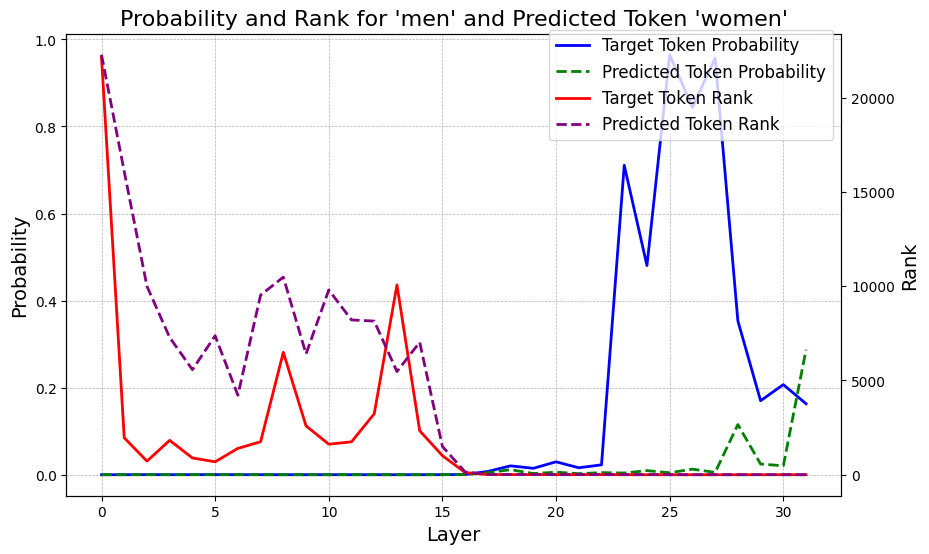

In [88]:
# intervene with MAN_VECTORS
from utils.hook_utils import *
from utils.extract_utils import get_prediction_per_layer
from transformer_lens import utils as tl_utils

tl_model.reset_hooks()
logits, cache = tl_model.run_with_cache(tokens, remove_batch_dim=True)

hook_logits = tl_model.run_with_hooks(
    tokens,
    fwd_hooks=\
        [(tl_utils.get_act_name("post", layer), partial(mlp_post_suppression_hook, position=-1, neuron=neuron)) for neuron, layer in MAN_VECTORS],
        # [(tl_utils.get_act_name("post", layer), partial(mlp_post_activate_hook, position=-1, neuron=neuron)) for neuron, layer in MAN_VECTORS],
    reset_hooks_end=False,
)
# short_hook_logits, short_hook_cache = hook_model.run_with_cache(short_tokens, remove_batch_dim=True)  # if not run this, hooks may stay
hook_cache = get_prediction_per_layer(
    tl_model, tokens, 
    target=target_id, 
    pos_idx=-1, 
    tokenizer=tokenizer, 
    is_plot=True, plot_output=True,
    return_cache=True
)
tl_model.reset_hooks()

## Weight Space Analysis: Extenstion to Confidence Regulation Neurons

In [93]:
MODEL_PATH="gpt2"
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True)
model.config.pad_token_id = model.config.eos_token_id
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
tokenizer.pad_token = tokenizer.eos_token
tl_model = HookedTransformer.from_pretrained(
        MODEL_PATH, hf_model=model, tokenizer=tokenizer, 
        torch_dtype=torch.bfloat16, device=device,
        fold_ln=False, center_writing_weights=False, center_unembed=False, fold_value_biases=False
        # fold_ln=True, center_writing_weights=True, center_unembed=True, fold_value_biases=True
)

/data2/hluo/anaconda3/envs/xllm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2 into HookedTransformer


In [94]:
# load the fully finetuned gpt-2 model
ft_path="/data2/hluo/checkpoints/llm_adapters/GPT-2/ARC-Challenge/full_ft"
ft_model = AutoModelForCausalLM.from_pretrained(ft_path, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True)
ft_model.config.pad_token_id = ft_model.config.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
ft_tl_model = HookedTransformer.from_pretrained(
        MODEL_PATH, hf_model=ft_model, tokenizer=tokenizer, 
        torch_dtype=torch.bfloat16, device=device,
        fold_ln=False, center_writing_weights=False, center_unembed=False, fold_value_biases=False
        # fold_ln=True, center_writing_weights=True, center_unembed=True, fold_value_biases=True
)

Loaded pretrained model gpt2 into HookedTransformer


In [95]:
def unembed_activation(hs, norm=tl_model.ln_final, unembed=tl_model.unembed):
    hs = norm(hs)
    logits = unembed(hs)
    return logits

def get_topk_logits2vocab(logits, top_k=10, tokenizer=tokenizer):
    probs = torch.softmax(logits, dim=-1)
    top_k_list = torch.topk(probs, k=top_k)
    print([f'{tokenizer.decode(top_k_list.indices[i])}: {top_k_list.values[i]} | ' for i in range(top_k)])
    return top_k_list

def generate_prompt_commonsense(instruction, input=None):
    if input:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: {instruction} ### Input: {input} ### Response:""" # noqa: E501
    else:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: {instruction} ### Response:""" # noqa: E501

import sys, json
dataset = json.load(open("ft-training_set/ARC-Challenge.json"))
sample_id = -1  # pick a shorter one?
suffix = "the correct answer is answer"
prompt = generate_prompt_commonsense(dataset[sample_id]['instruction']) + " " + suffix
tokens = tokenizer.encode(prompt, return_tensors="pt").to(device)
input_tokens_len = len(tokenizer.encode(dataset[sample_id]['instruction'], return_tensors="pt")[0])
prefix_tokens_len = len(tokenizer.encode("Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction:", return_tensors="pt")[0])
suffix_tokens_len = len(tokenizer.encode("### Response:" + " " + suffix, return_tensors="pt")[0])
# assert tokens.size(1) == prefix_tokens_len + input_tokens_len + suffix_tokens_len
str_tokens = tokenizer.convert_ids_to_tokens(tokens[0])


tgt = dataset[sample_id]["answer"]
# use regular expression to subtract the digit from tgt
import re
tgt = re.sub(r'[^\d]', '', tgt)
tgt_token = tokenizer.convert_tokens_to_ids(tgt)
print(tgt)

torch.set_grad_enabled(False)
torch.cuda.empty_cache()
torch.set_grad_enabled(True)
logits, cache = tl_model.run_with_cache(tokens, return_type="loss", remove_batch_dim=True, incl_bwd=True)
if ft_tl_model is not None:
    def ft_unembed_activation(hs, norm=ft_tl_model.ln_final, unembed=ft_tl_model.unembed):
        hs = norm(hs)
        logits = unembed(hs)
        return logits
    ft_logits, ft_cache = ft_tl_model.run_with_cache(tokens, return_type="loss", remove_batch_dim=True, incl_bwd=True)

3


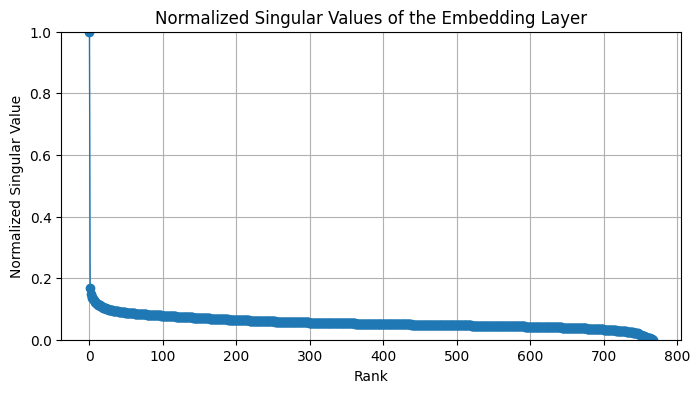

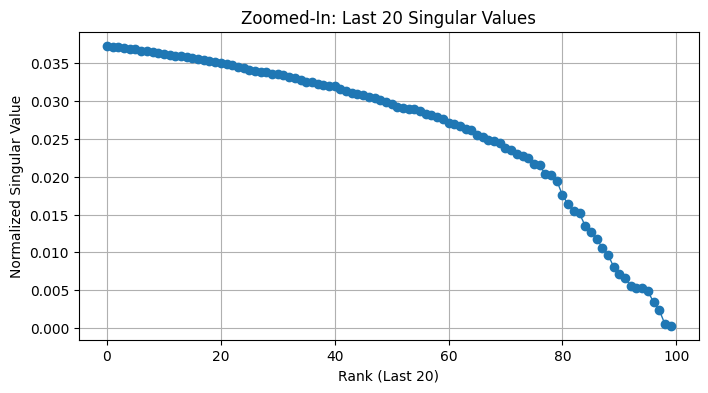

In [110]:
# svd for W_U and zoom in
import torch
import matplotlib.pyplot as plt

def compute_singular_values(current_weight):
    u, s, v = torch.svd(current_weight) 
    return s

def visualize_singular_values_embedding():
    # Fetch the gradient of the unembedding weights
    current_weights = tl_model.unembed.W_U.detach().float()  # Shape: (hidden_dim, vocabulary_length)
    singular_values = compute_singular_values(current_weights)
    singular_values = singular_values / singular_values.max()
    

    plt.figure(figsize=(8, 4))
    plt.plot(singular_values.cpu().numpy(), marker='o', linestyle='-', linewidth=1)
    plt.title("Normalized Singular Values of the Embedding Layer")
    plt.xlabel('Rank')
    plt.ylabel('Normalized Singular Value')
    plt.grid(True) 
    plt.ylim(0, 1) 
    
    plt.figure(figsize=(8, 4))
    plt.plot(singular_values.cpu().numpy()[-100:], marker='o', linestyle='-', linewidth=1)  # Zoom in on the last 20 values
    plt.title("Zoomed-In: Last 20 Singular Values")
    plt.xlabel('Rank (Last 20)')
    plt.ylabel('Normalized Singular Value')
    plt.grid(True)
    # plt.ylim(0, 1) 
    plt.show()

visualize_singular_values_embedding()


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


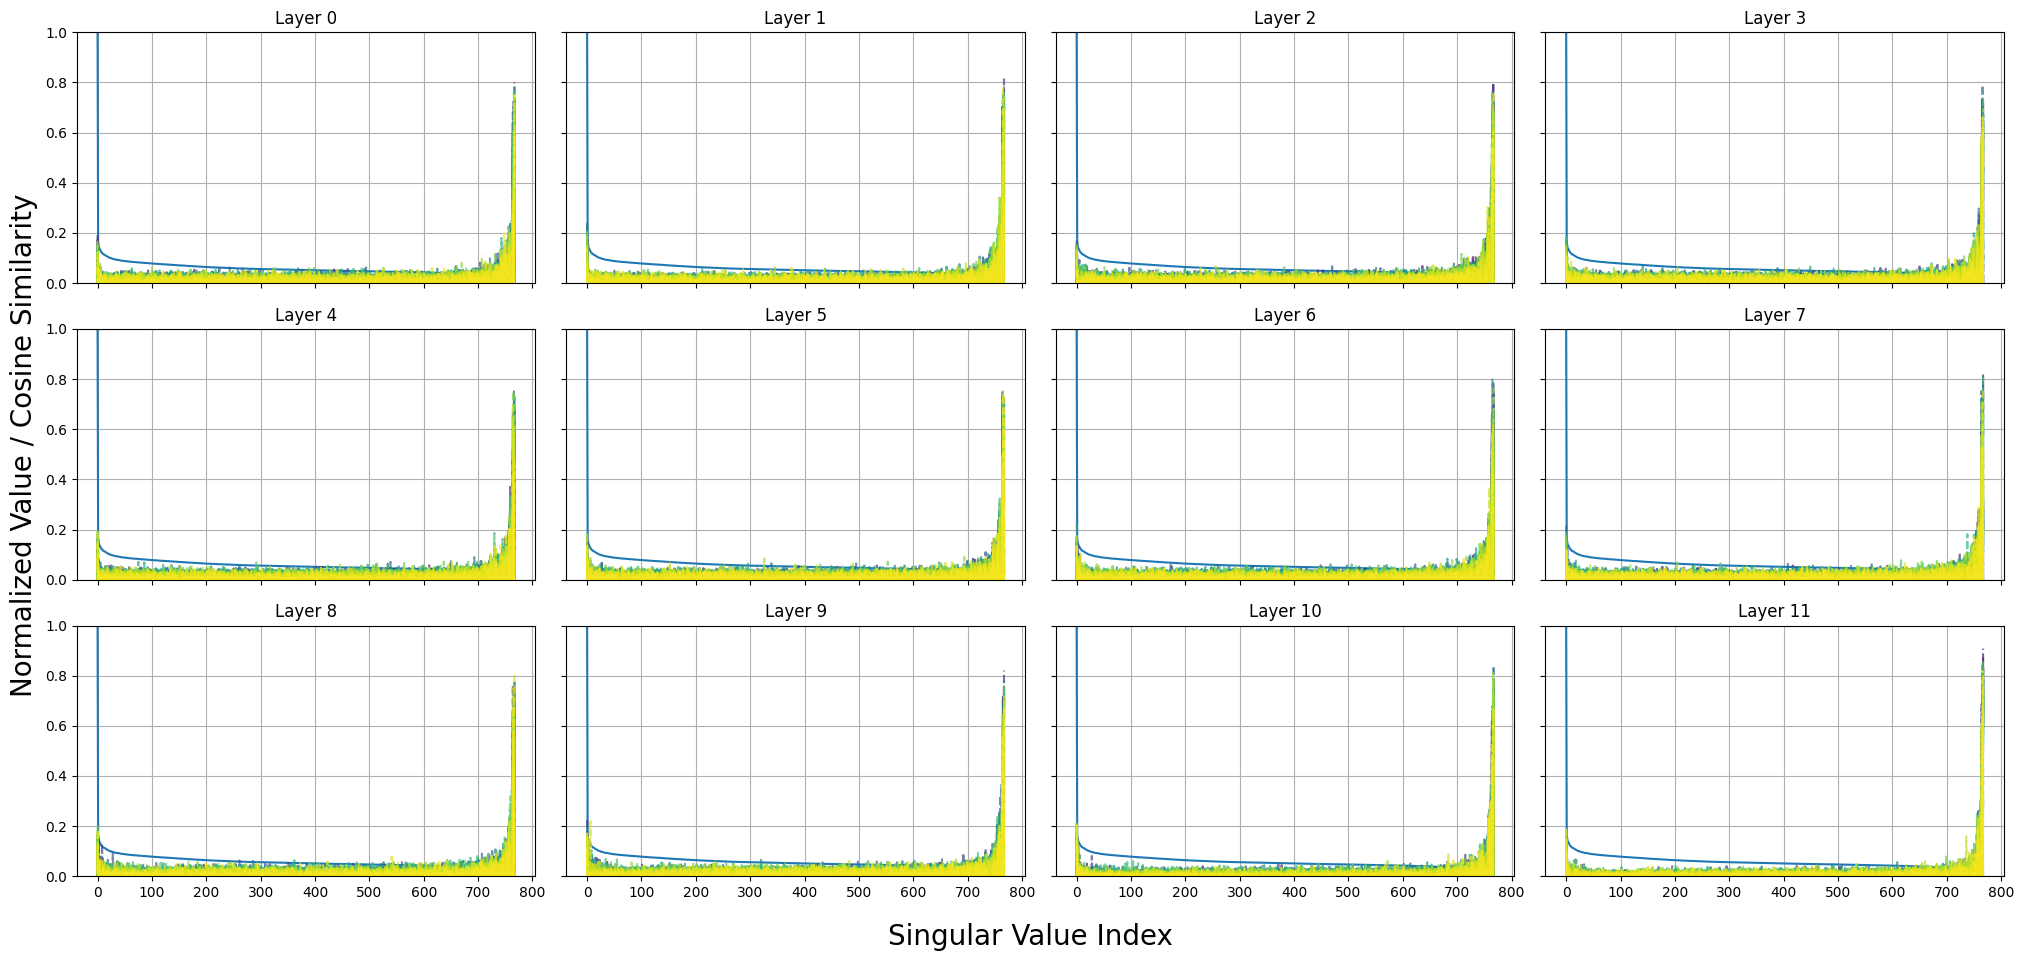

In [112]:
# between W_U and selected vectors according to some metric with null space
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def compute_singular_values_and_v_matrix(weights):
    """Compute the singular values and the V matrix of a weight matrix."""
    u, s, v = torch.svd(weights)  # Perform Singular Value Decomposition
    return s, v

def compute_cosine_similarity(matrix, vector):
    """Compute the cosine similarity between a matrix and a vector."""
    norm_matrix = matrix / (torch.norm(matrix, dim=0, keepdim=True) + 1e-8)
    norm_vector = vector / (torch.norm(vector) + 1e-8)
    cosine_similarity = torch.mm(norm_matrix.t(), norm_vector.unsqueeze(1)).squeeze(1)
    return cosine_similarity

def visualize_singular_values_and_grad_cosine_similarity(cache, num_layers=tl_model.cfg.n_layers):
    fig, axes = plt.subplots(tl_model.cfg.n_layers // 4, 4, figsize=(20, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    weights = tl_model.unembed.W_U.detach().float().T  # Shape: (mlp_dimension, hidden_dimension d)
    singular_values, v_matrix = compute_singular_values_and_v_matrix(weights)
    null_space = v_matrix[:, -10:]  # Shape: (hidden_dimension d, 10)
    
    layer_top_k_indices = []

    for layer_index in tqdm(range(num_layers)):
        current_weights = tl_model.blocks[layer_index].mlp.W_out
        current_weights = tl_model.ln_final(current_weights.unsqueeze(0)).squeeze(0).detach().float()
        
        # Compute Fraction of Norm in Null Space (ρ)
        rho = []
        for i in range(current_weights.shape[0]):
            current_weight = current_weights[i, :]
            norm_grad = torch.norm(current_weight)
            norm_null_space_projection = torch.norm(torch.mm(null_space.t(), current_weight.unsqueeze(1)))
            rho_value = norm_null_space_projection / (norm_grad + 1e-8)
            rho.append(rho_value.item())
        
        rho_tensor = torch.tensor(rho)
        top_k_indices = torch.topk(rho_tensor, 100, largest=True).indices
        layer_top_k_indices.append(top_k_indices.cpu().numpy())  # Store top_k_indices for this layer
        
        top_k_rho_values = rho_tensor[top_k_indices]
        # print(f"Layer {layer_index} - Top 10 ρ values: {top_k_rho_values.numpy()}")
        # print(f"Layer {layer_index} - Top 10 ρ indices: {top_k_indices}")

        cosine_similarities = []
        for i in top_k_indices:
            cosine_similarity = compute_cosine_similarity(v_matrix, current_weights[i, :])
            cosine_similarities.append(cosine_similarity.cpu().numpy())
        
        singular_values_normalized = singular_values / singular_values.max()

        ax = axes[layer_index]
        ax.plot(singular_values_normalized.cpu().numpy(), linestyle='-', label='Singular Values')
        
        cmap = plt.get_cmap('viridis')
        num_grads = len(cosine_similarities)
        for i, similarity in enumerate(cosine_similarities):
            color = cmap(i / num_grads)
            ax.plot(similarity, linestyle='--', color=color, alpha=0.7)
        
        ax.set_title(f"Layer {layer_index}")
        ax.grid(True)
        ax.set_ylim(0, 1)
        
    fig.text(0.5, 0, 'Singular Value Index', ha='center', fontsize=20)
    fig.text(-0.01, 0.5, 'Normalized Value / Cosine Similarity', va='center', rotation='vertical', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return layer_top_k_indices

layer_top_k_indices = visualize_singular_values_and_grad_cosine_similarity(cache)

100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


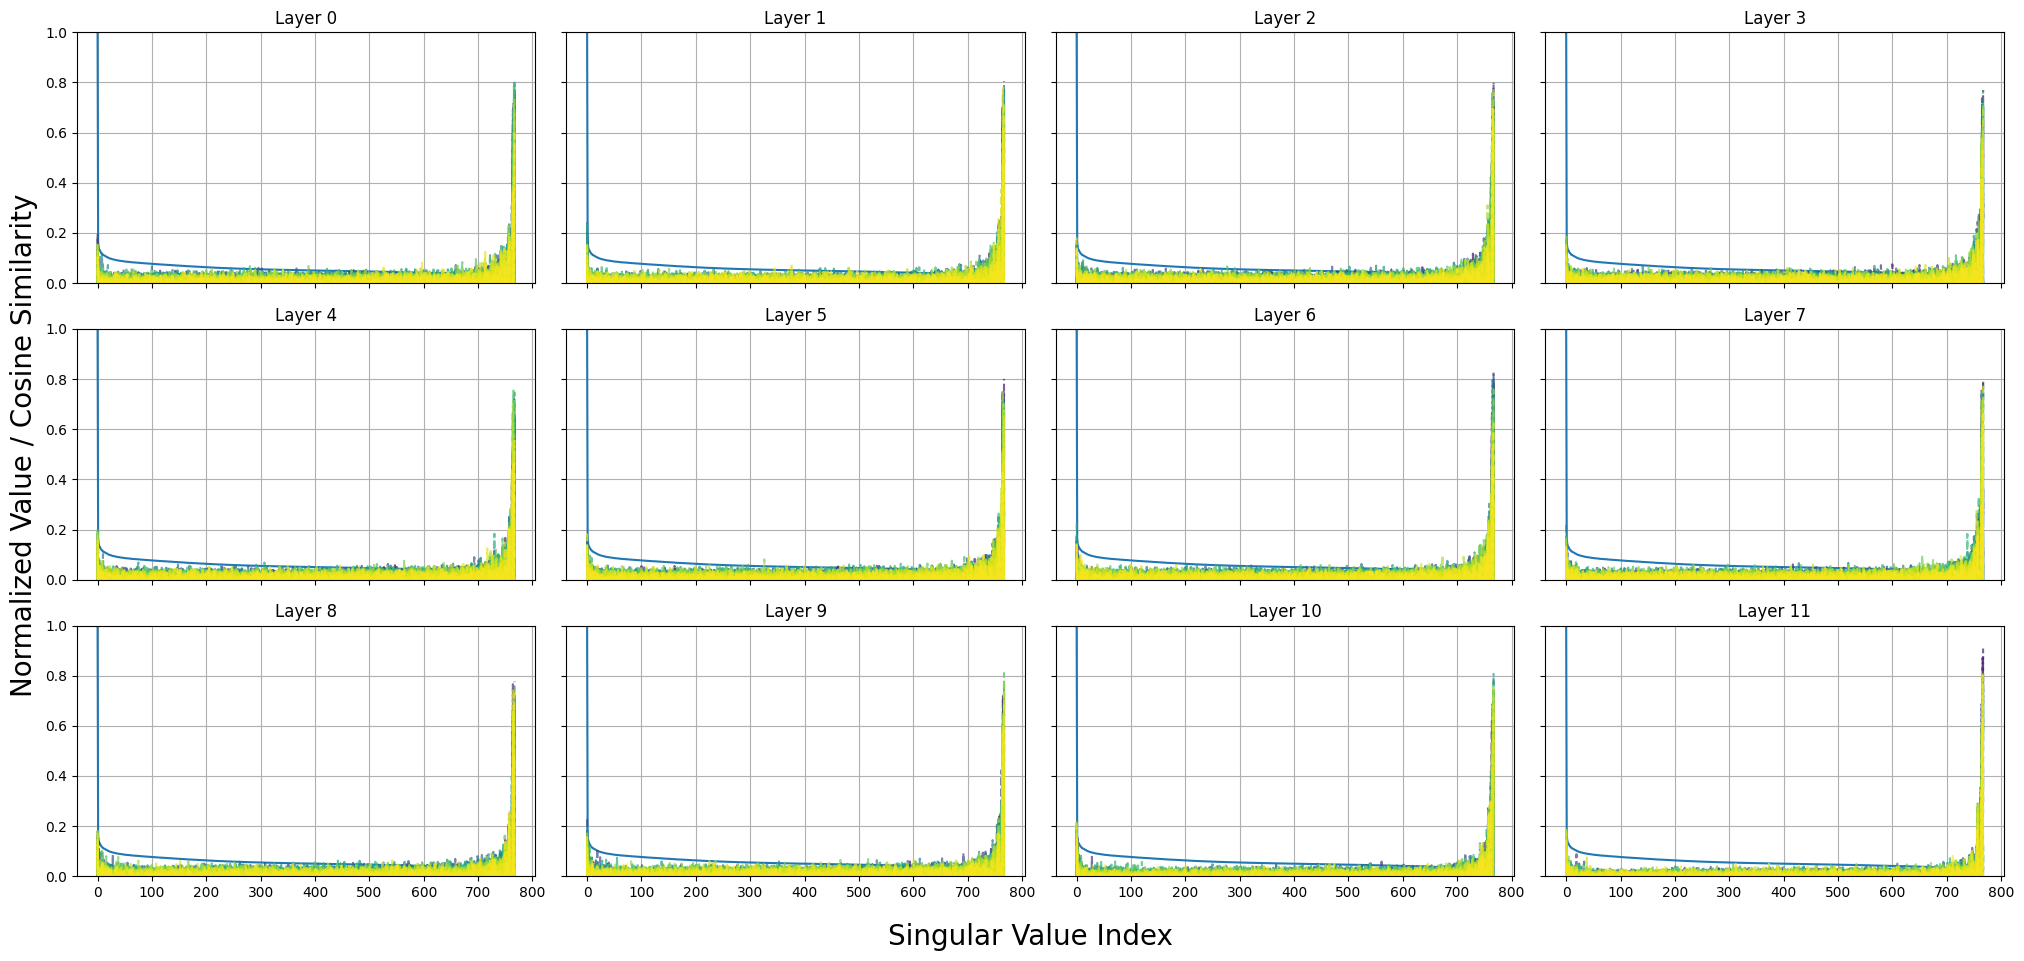

In [113]:
def visualize_singular_values_and_grad_cosine_similarity(cache, num_layers=ft_tl_model.cfg.n_layers):
    fig, axes = plt.subplots(ft_tl_model.cfg.n_layers // 4, 4, figsize=(20, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    weights = ft_tl_model.unembed.W_U.detach().float().T  # Shape: (mlp_dimension, hidden_dimension d)
    singular_values, v_matrix = compute_singular_values_and_v_matrix(weights)
    null_space = v_matrix[:, -10:]  # Shape: (hidden_dimension d, 10)
    
    layer_top_k_indices = []

    for layer_index in tqdm(range(num_layers)):
        current_weights = ft_tl_model.blocks[layer_index].mlp.W_out
        current_weights = ft_tl_model.ln_final(current_weights.unsqueeze(0)).squeeze(0).detach().float()
        
        # Compute Fraction of Norm in Null Space (ρ)
        rho = []
        for i in range(current_weights.shape[0]):
            current_weight = current_weights[i, :]
            norm_grad = torch.norm(current_weight)
            norm_null_space_projection = torch.norm(torch.mm(null_space.t(), current_weight.unsqueeze(1)))
            rho_value = norm_null_space_projection / (norm_grad + 1e-8)
            rho.append(rho_value.item())
        
        rho_tensor = torch.tensor(rho)
        top_k_indices = torch.topk(rho_tensor, 100, largest=True).indices
        layer_top_k_indices.append(top_k_indices.cpu().numpy())  # Store top_k_indices for this layer
        
        top_k_rho_values = rho_tensor[top_k_indices]
        # print(f"Layer {layer_index} - Top 10 ρ values: {top_k_rho_values.numpy()}")
        # print(f"Layer {layer_index} - Top 10 ρ indices: {top_k_indices}")

        cosine_similarities = []
        for i in top_k_indices:
            cosine_similarity = compute_cosine_similarity(v_matrix, current_weights[i, :])
            cosine_similarities.append(cosine_similarity.cpu().numpy())
        
        singular_values_normalized = singular_values / singular_values.max()

        ax = axes[layer_index]
        ax.plot(singular_values_normalized.cpu().numpy(), linestyle='-', label='Singular Values')
        
        cmap = plt.get_cmap('viridis')
        num_grads = len(cosine_similarities)
        for i, similarity in enumerate(cosine_similarities):
            color = cmap(i / num_grads)
            ax.plot(similarity, linestyle='--', color=color, alpha=0.7)
        
        ax.set_title(f"Layer {layer_index}")
        ax.grid(True)
        ax.set_ylim(0, 1)
        
    fig.text(0.5, 0, 'Singular Value Index', ha='center', fontsize=20)
    fig.text(-0.01, 0.5, 'Normalized Value / Cosine Similarity', va='center', rotation='vertical', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return layer_top_k_indices

tuned_layer_top_k_indices = visualize_singular_values_and_grad_cosine_similarity(cache)

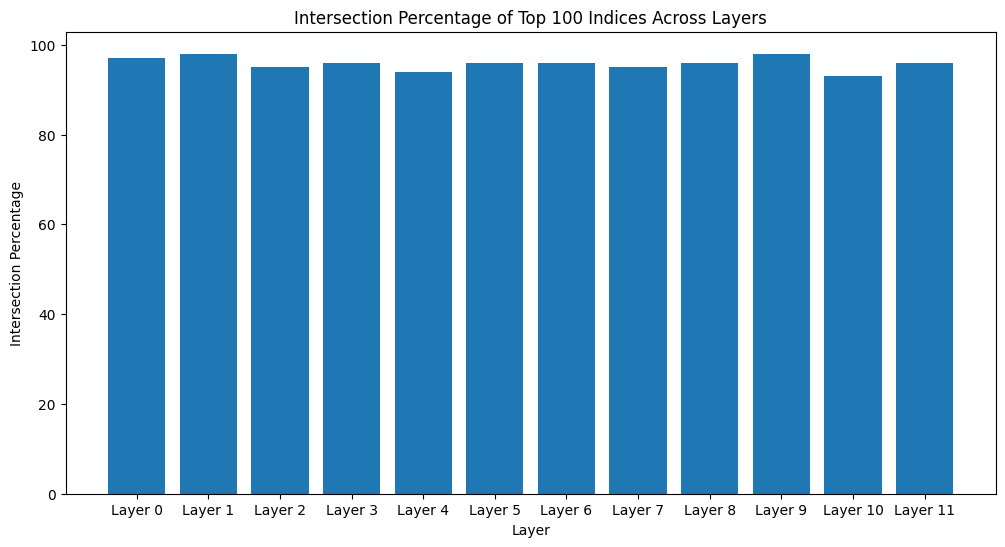

In [116]:
def calculate_intersection_percentage(layer_top_k_indices, other_top_k_indices):
    intersection_percentages = []
    
    for i in range(len(layer_top_k_indices)):
        intersection = np.intersect1d(layer_top_k_indices[i], other_top_k_indices[i])
        percentage = (len(intersection) / len(layer_top_k_indices[i])) * 100
        intersection_percentages.append(percentage)
    
    return intersection_percentages

def plot_intersection_percentages(intersection_percentages):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(intersection_percentages)), intersection_percentages)
    plt.xlabel("Layer")
    plt.ylabel("Intersection Percentage")
    plt.title("Intersection Percentage of Top 100 Indices Across Layers")
    plt.xticks(range(len(intersection_percentages)), labels=[f'Layer {i}' for i in range(len(intersection_percentages))])
    plt.show()

intersection_percentages = calculate_intersection_percentage(layer_top_k_indices, tuned_layer_top_k_indices)
plot_intersection_percentages(intersection_percentages)

 83%|████████▎ | 10/12 [00:00<00:00, 19.53it/s]

100%|██████████| 12/12 [00:00<00:00, 19.41it/s]


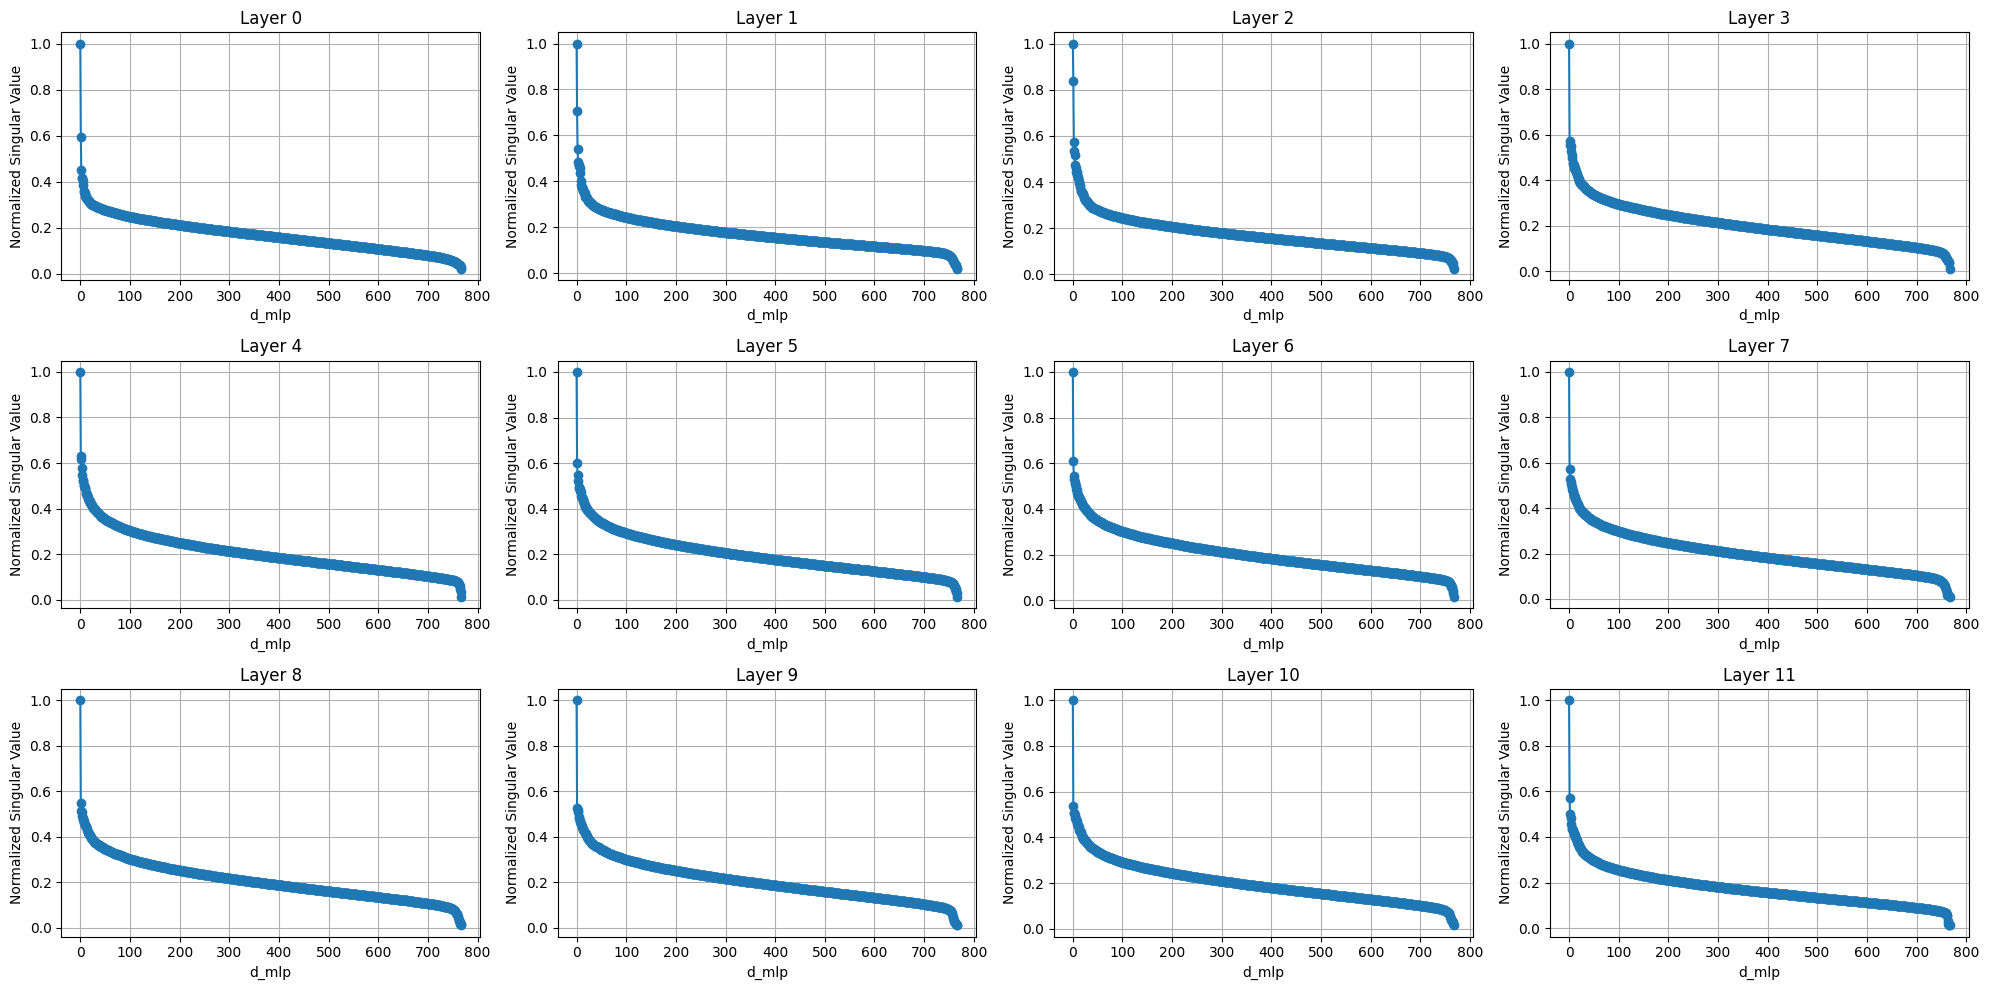

In [123]:
# for basic singular values decomposition for W_in
def visualize_singular_values(cache, num_layers=tl_model.cfg.n_layers):
    fig, axes = plt.subplots(num_layers // 4, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for layer_index in tqdm(range(num_layers)):
        current_weights = tl_model.blocks[layer_index].mlp.W_in.detach().float()  # Shape: (num_tokens, gradient_dimension)
        singular_values = compute_singular_values(current_weights.T)
        singular_values_normalized = singular_values / singular_values.max()
        ax = axes[layer_index]
        ax.plot(singular_values_normalized.cpu().numpy(), marker='o', linestyle='-')
        ax.set_title(f"Layer {layer_index}")
        ax.set_xlabel('d_mlp')
        ax.set_ylabel('Normalized Singular Value')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

visualize_singular_values(cache)


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


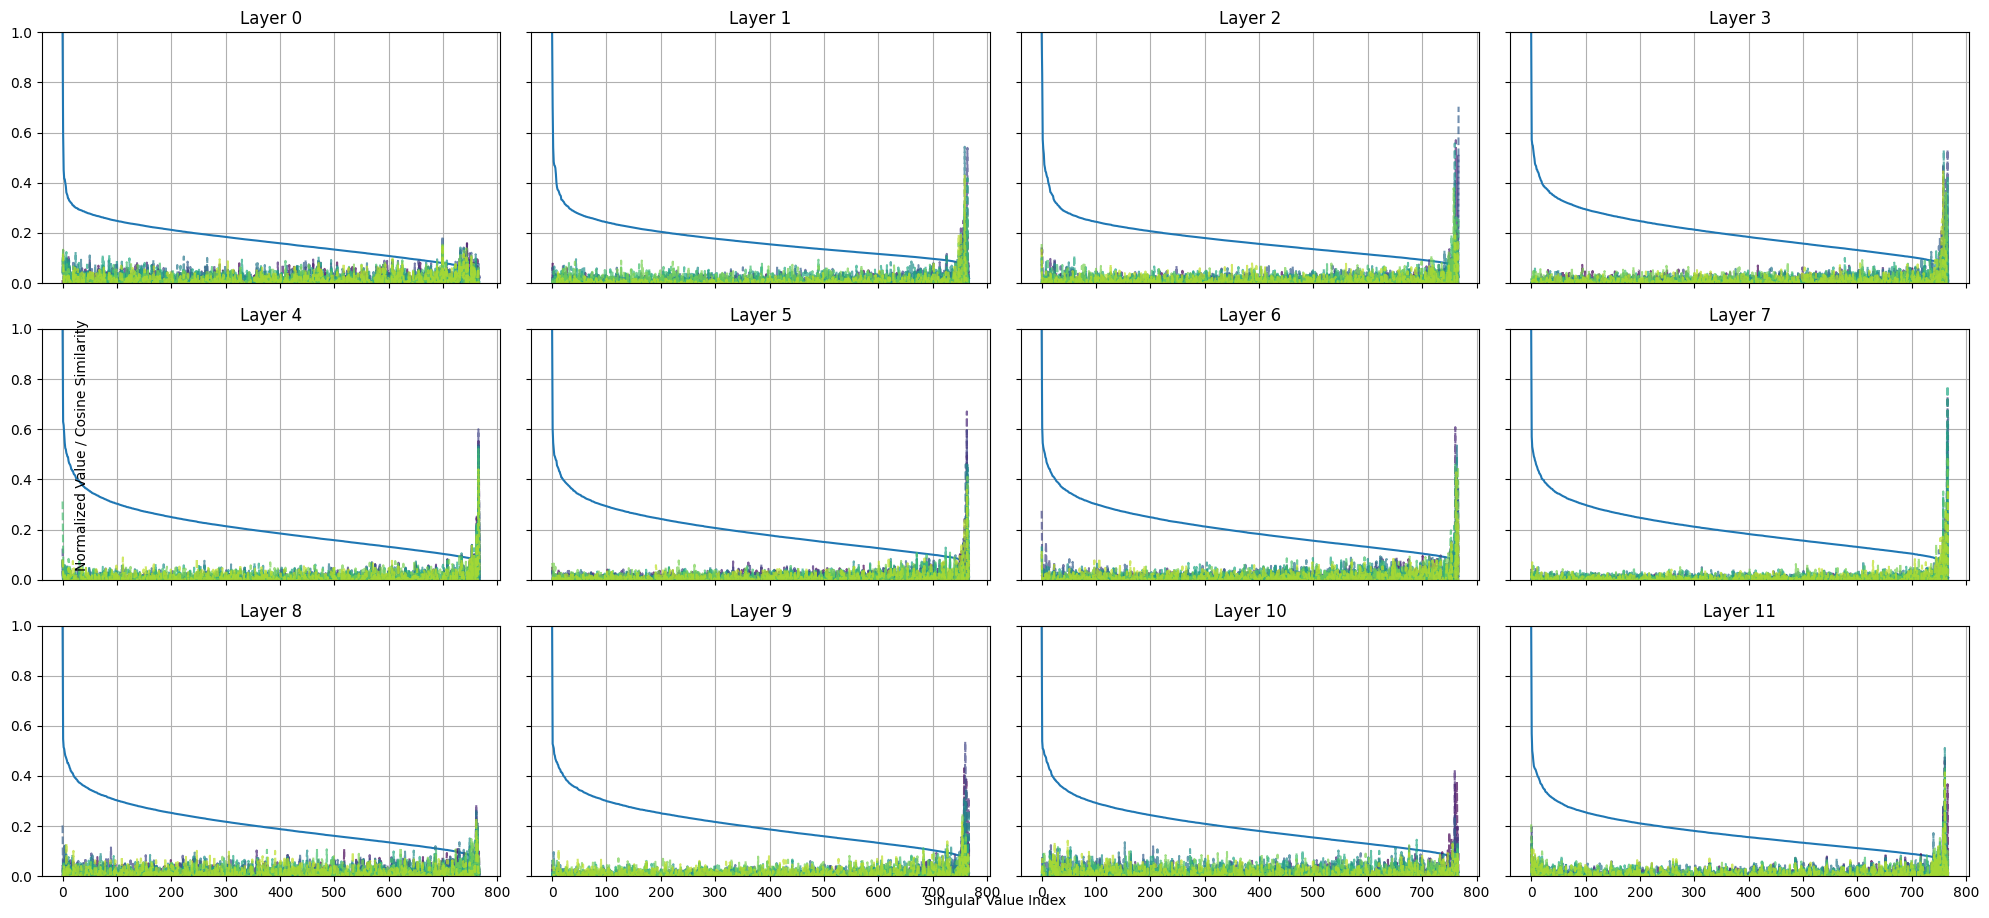

In [124]:
# comparison with previous layers vectors, current_weights first weights second
def visualize_singular_values_and_grad_cosine_similarity(cache, num_layers=tl_model.cfg.n_layers):
    fig, axes = plt.subplots(tl_model.cfg.n_layers // 4, 4, figsize=(20, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for layer_index in tqdm(range(num_layers)):
        weights = tl_model.blocks[layer_index].mlp.W_in.detach().float().T  # Shape: (mlp_dimension, hidden_dimension d)

        if layer_index == 0:
            current_weights = tl_model.embed.W_E.detach().float()  # Shape: (vocab_size, hidden_dimension d)
        else:
            current_weights = tl_model.blocks[layer_index - 1].mlp.W_out.detach().float()  # Shape: (mlp_dimension, hidden_dimension d)

        singular_values, v_matrix = compute_singular_values_and_v_matrix(weights)
        
        null_space = v_matrix[:, -10:]  # Shape: (hidden_dimension d, 10)
        rho = []
        for i in range(current_weights.shape[0]):
            current_weight = current_weights[i, :]
            norm_grad = torch.norm(current_weight)
            norm_null_space_projection = torch.norm(torch.mm(null_space.t(), current_weight.unsqueeze(1)))
            rho_value = norm_null_space_projection / (norm_grad + 1e-8)
            rho.append(rho_value.item())
        
        rho_tensor = torch.tensor(rho)
        top_k_indices = torch.topk(rho_tensor, 10, largest=True).indices
        top_k_rho_values = rho_tensor[top_k_indices]
        # print(f"Layer {layer_index} - Top 10 ρ values: {top_k_rho_values.numpy()}")
        # print(f"Layer {layer_index} - Top 10 ρ indices: {top_k_indices}")

        cosine_similarities = []
        for i in top_k_indices:
            cosine_similarity = compute_cosine_similarity(v_matrix, current_weights[i, :])
            cosine_similarities.append(cosine_similarity.cpu().numpy())
        
        singular_values_normalized = singular_values / singular_values.max()
        ax = axes[layer_index]
        # ax.plot(singular_values_normalized.cpu().numpy()[-30:], linestyle='-', label='Singular Values')
        ax.plot(singular_values_normalized.cpu().numpy(), linestyle='-', label='Singular Values')
        cmap = plt.get_cmap('viridis')
        num_grads = len(cosine_similarities)
        for i, similarity in enumerate(cosine_similarities):
            color = cmap(i / num_grads)
            # ax.plot(similarity[-30:], linestyle='--', color=color, alpha=0.7)
            ax.plot(similarity, linestyle='--', color=color, alpha=0.7)
        
        ax.set_title(f"Layer {layer_index}")
        ax.grid(True)
        ax.set_ylim(0, 1)

    fig.text(0.5, 0.04, 'Singular Value Index', ha='center')
    fig.text(0.04, 0.5, 'Normalized Value / Cosine Similarity', va='center', rotation='vertical')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

visualize_singular_values_and_grad_cosine_similarity(cache)
